In [16]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

In [17]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [18]:
covid_19_df = pd.read_csv('covid_19_clean_complete.csv', parse_dates=True, dayfirst=False)

In [19]:
covid_19_df = pd.read_csv('covid_19_clean_complete.csv')
covid_19_df['Date'] = pd.to_datetime(covid_19_df['Date'])
covid_19_df['Country/Region'] = covid_19_df['Country/Region'].replace('Mainland China', 'China')
covid_19_df.tail(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
18316,"Bonaire, Sint Eustatius and Saba",Netherlands,12.178400,-68.238500,2020-04-01,0,0,0.0
18317,NaN,Malawi,-13.254308,34.301525,2020-04-01,0,0,0.0


In [20]:
cases = ['Confirmed', 'Active', 'Recovered', 'Deaths']
growth = ['Confirmed_growth', 'Deaths_growth', 'Recovered_growth', 'Confirmed_growth_mean']
covid_19_df['Active'] = covid_19_df['Confirmed'] - covid_19_df['Deaths'] - covid_19_df['Recovered']
covid_19_df = covid_19_df.sort_values(by=['Date'], ascending=True)
covid_19_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0.0,0.0
164,NaN,Namibia,-22.9576,18.4904,2020-01-22,0,0,0.0,0.0


### Finding Countries with most confirmed cases

In [21]:
last_covid_df = covid_19_df[covid_19_df['Date'] == covid_19_df['Date'].max()].reset_index(drop=True)
last_covid_df = last_covid_df.drop(columns=['Lat', 'Long'])
top_50 = last_covid_df.groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(50)
grouped_Poland = top_50[top_50.index == "Poland"]
top_10 = last_covid_df.groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(10)
top_10_with_Poland  = pd.concat([top_10, grouped_Poland])

In [22]:
def prepare_data(df, country, *lower_bound):
    df = df[df['Country/Region'] == country]
    if (country == 'China') | (country == 'US') | (country == 'Australia') | (country == 'Canada') | (country == 'Denmark') | (country == 'France') | (country == 'United Kingdom') | (country == 'Netherlands'):
        df = df.groupby('Date').sum().reset_index()
    elif df[df['Province/State'] == country].notna().any().any():
        df = df[df['Province/State'] == country]
    df = df.sort_values(by='Date').reset_index(drop=True)

    if lower_bound:
        df = df[df.Confirmed > lower_bound].reset_index(drop=True)
    date_range = df['Date'].sort_values().drop_duplicates().reset_index(drop=True)
    date_range = date_range.dt.strftime('%d-%m')
    return df, date_range

In [23]:
def show_increment(df, label, date_range):
    my_xticks = range(0, len(date_range), 5)
    my_xticks_labels = list(date_range)[0:len(date_range):5]
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax1 = sns.lineplot(data=df[cases], ax=ax)
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel(label)
    plt.show()
    
    print('\nDaily growth for each types of cases\n')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(23, 5))
    ax1 = sns.barplot(x=date_range.index, y='Confirmed_growth', data=df, ax=ax1, palette=cm.Blues(df.Confirmed_growth/max(df.Confirmed_growth*1.5)+0.3))
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel('Daily Confirmed growth')
    ax1.set_ylabel('Cases')
    
    ax2 = sns.barplot(x=date_range.index, y='Deaths_growth', data=df, ax=ax2, palette=cm.autumn_r(df.Deaths_growth/max(df.Deaths_growth*1.5)+0.3))
    ax2.set_xticks(my_xticks)
    ax2.set_xticklabels(my_xticks_labels)
    ax2.set_xlabel('Daily Deaths growth')
    ax2.set_ylabel('Cases')
    
    ax3 = sns.barplot(x=date_range.index, y='Recovered_growth', data=df, ax=ax3, palette=cm.Greens(df.Recovered_growth/max(df.Recovered_growth)+0.3))
    ax3.set_xticks(my_xticks)
    ax3.set_xticklabels(my_xticks_labels)
    ax3.set_xlabel('Daily Recovered growth')
    ax3.set_ylabel('Cases')
    
    plt.show()

In [24]:
def add_data(covid_19_df):
    covid_19_df['Confirmed_growth'] = covid_19_df['Confirmed'] - covid_19_df['Confirmed'].shift()
    covid_19_df['Confirmed_growth'][0] = covid_19_df['Confirmed'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Deaths_growth'] = covid_19_df['Deaths'] - covid_19_df['Deaths'].shift()
    covid_19_df['Deaths_growth'][0] = covid_19_df['Deaths'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Recovered_growth'] = covid_19_df['Recovered'] - covid_19_df['Recovered'].shift()
    covid_19_df['Recovered_growth'][0] = covid_19_df['Recovered'][0]
    covid_19_df = covid_19_df.fillna(0)
    return covid_19_df

### Plot for 10 countries with most confirmed cases with start data: 50 confirmed cases<br> on one plot

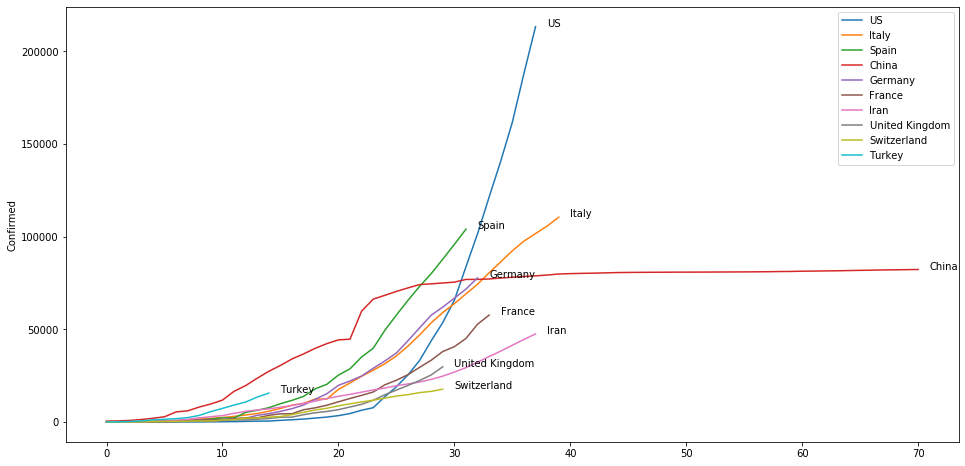

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))

for index, country in enumerate(top_10.index):
    df, date_range = prepare_data(covid_19_df, country, 50)
    x=df.index
    y=df.Confirmed    
    ax = sns.lineplot(x=x, y=y, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')

plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot without US

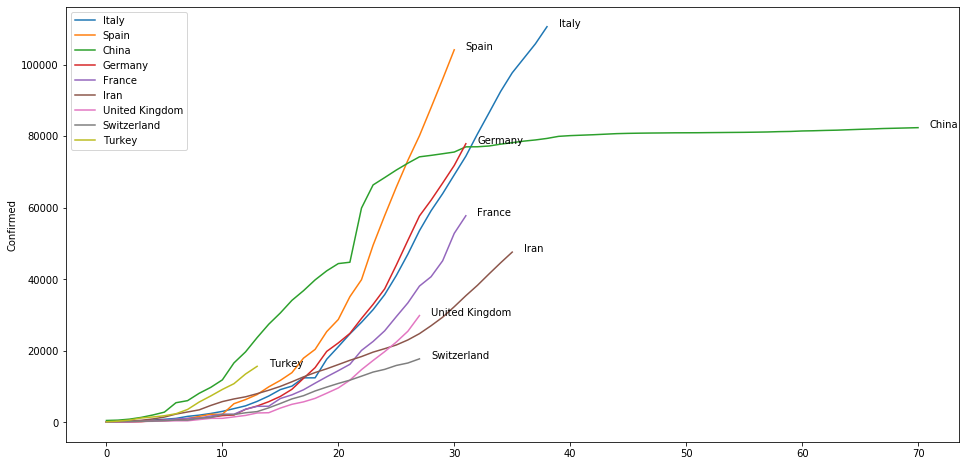

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10.index[1:10]):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot with Poland

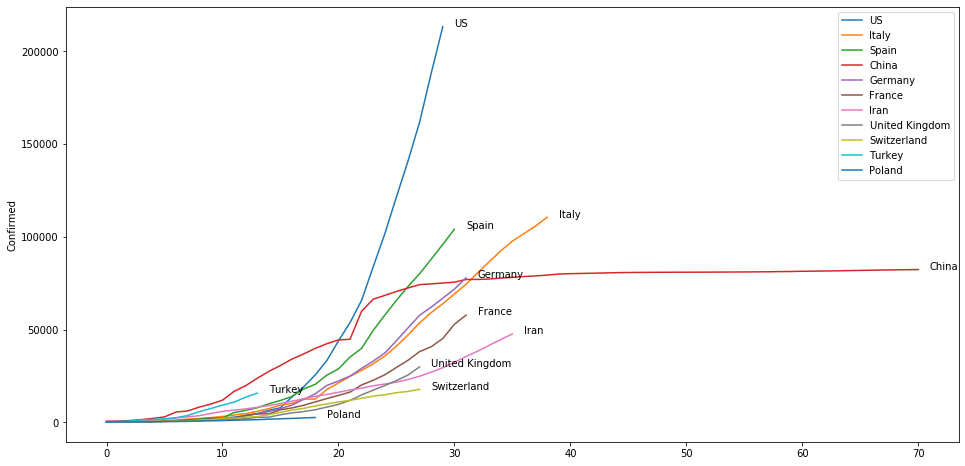

In [27]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10_with_Poland.index):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
    
plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot without China & Italy with Poland

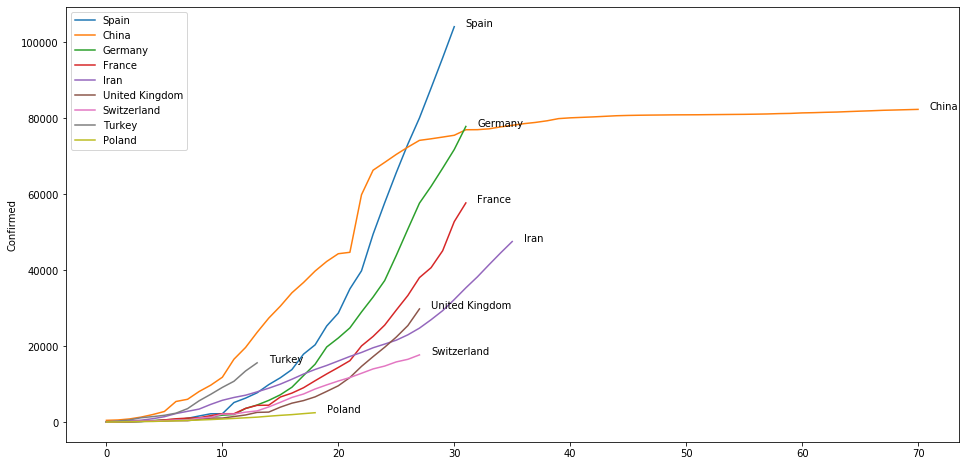

In [28]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10_with_Poland.index[2:]):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
    
plt.show()

### Plots for 50 countries with most confirmed cases with start data: 50 confirmed cases

The line plot presents all data in the following days starting from the moment when there were more than 50 confirmed cases.<br>
The bar plots show the daily increase in each category. There are some days with negative values caused by changes in the data tables in the source data - maybe some of the cases were wrongly classified as recovered and therefore were removed. 

1 . US
Confirmed: 213372 
Active: 200141.0 
Recovered: 8474.0 
Deaths: 4757


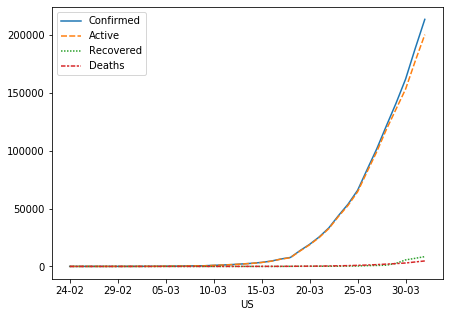


Daily growth for each types of cases



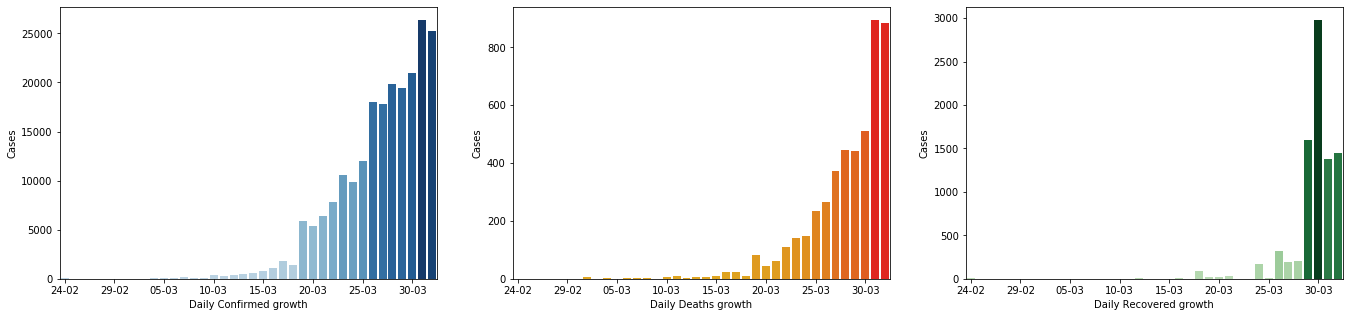

2 . Italy
Confirmed: 110574 
Active: 80572.0 
Recovered: 16847.0 
Deaths: 13155


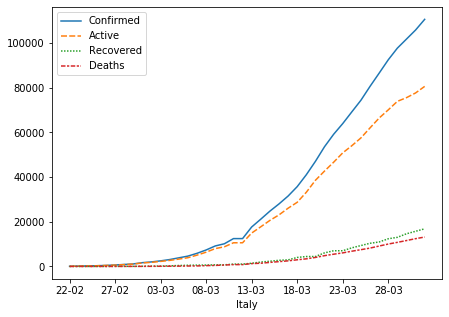


Daily growth for each types of cases



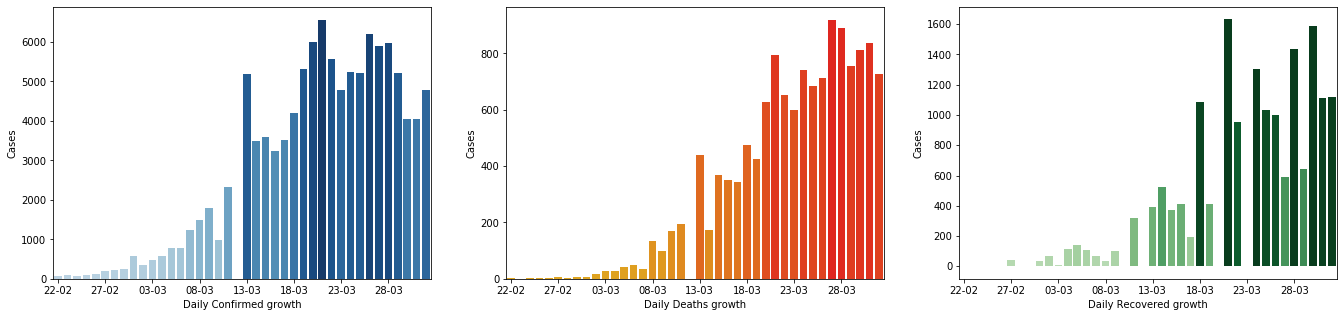

3 . Spain
Confirmed: 104118 
Active: 72084.0 
Recovered: 22647.0 
Deaths: 9387


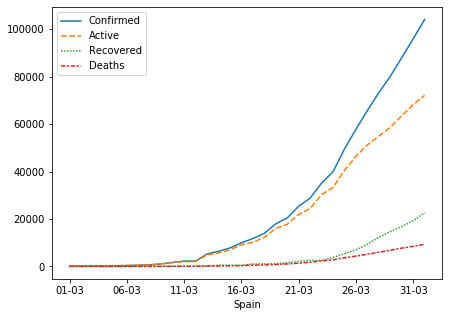


Daily growth for each types of cases



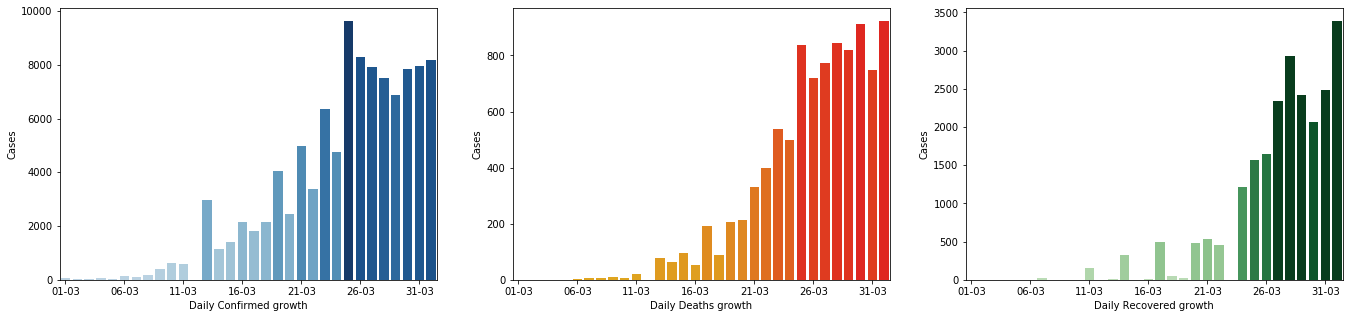

4 . China
Confirmed: 82361 
Active: 2640.0 
Recovered: 76405.0 
Deaths: 3316


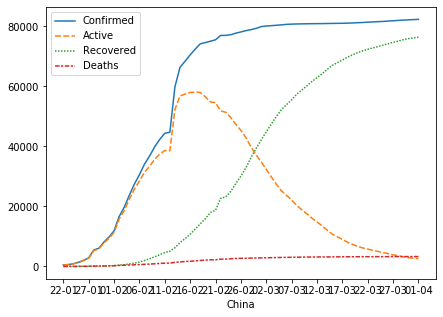


Daily growth for each types of cases



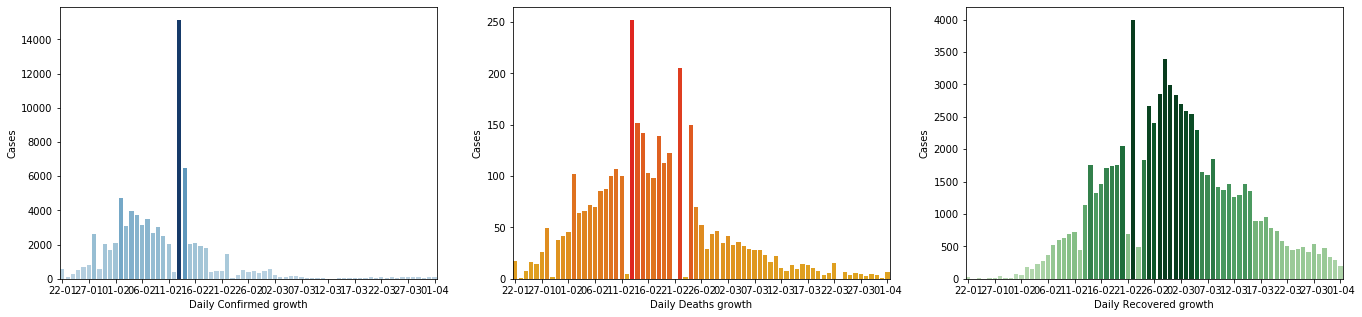

5 . Germany
Confirmed: 77872 
Active: 58252.0 
Recovered: 18700.0 
Deaths: 920


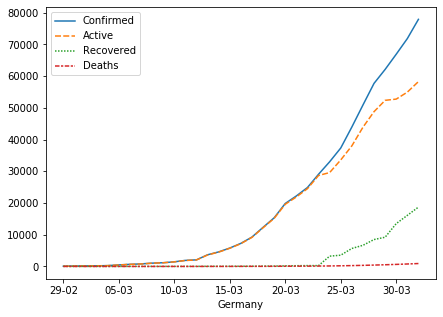


Daily growth for each types of cases



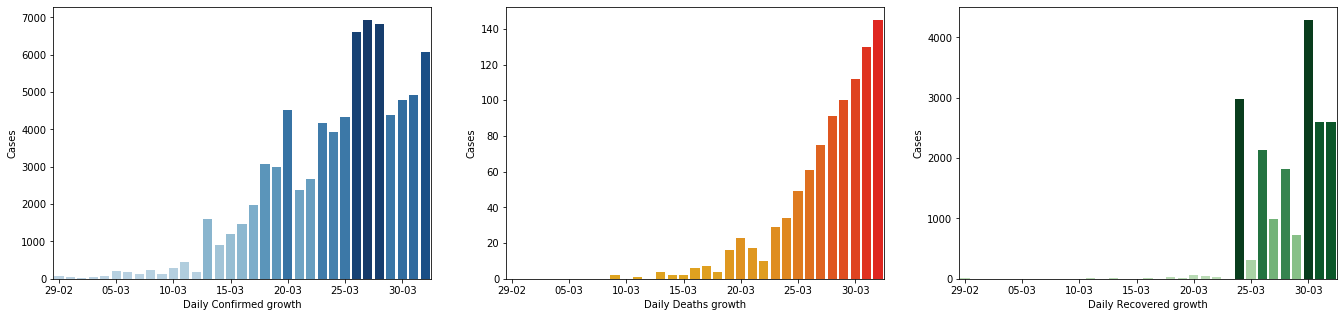

6 . France
Confirmed: 57749 
Active: 42653.0 
Recovered: 11053.0 
Deaths: 4043


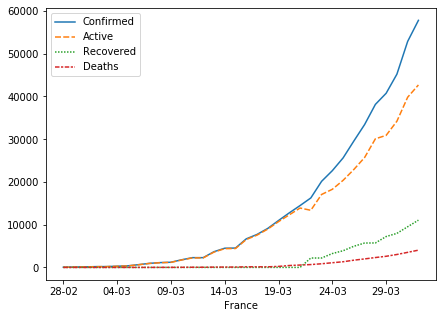


Daily growth for each types of cases



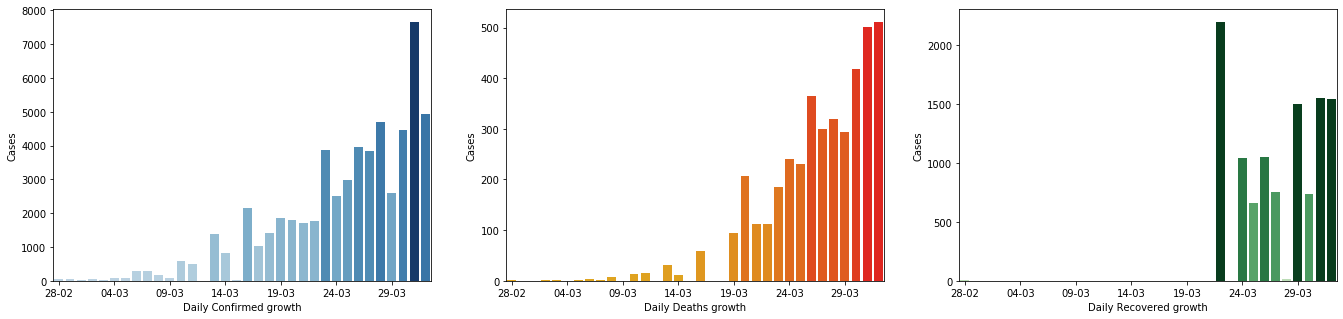

7 . Iran
Confirmed: 47593 
Active: 29084.0 
Recovered: 15473.0 
Deaths: 3036


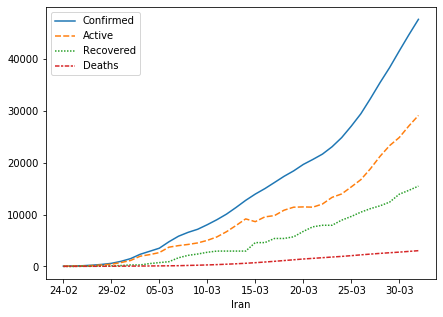


Daily growth for each types of cases



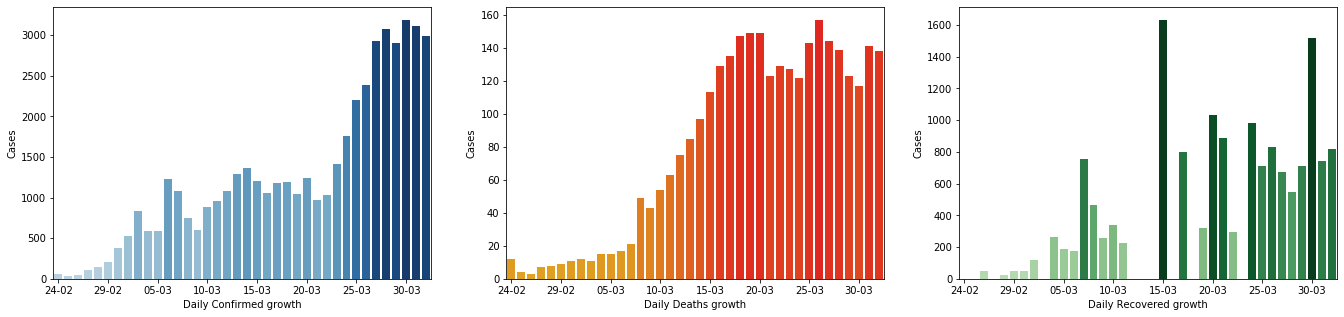

8 . United Kingdom
Confirmed: 29865 
Active: 27329.0 
Recovered: 179.0 
Deaths: 2357


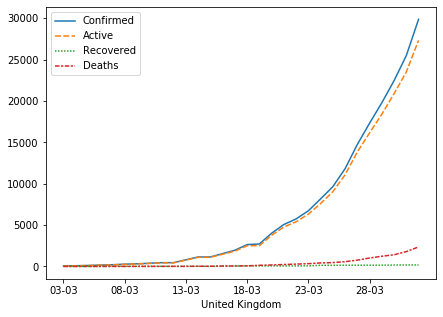


Daily growth for each types of cases



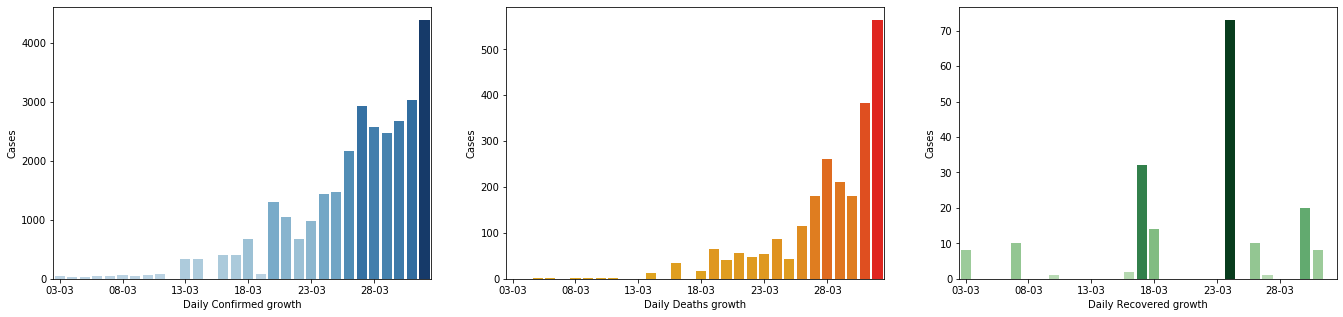

9 . Switzerland
Confirmed: 17768 
Active: 14313.0 
Recovered: 2967.0 
Deaths: 488


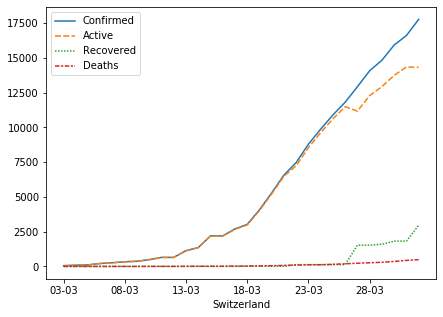


Daily growth for each types of cases



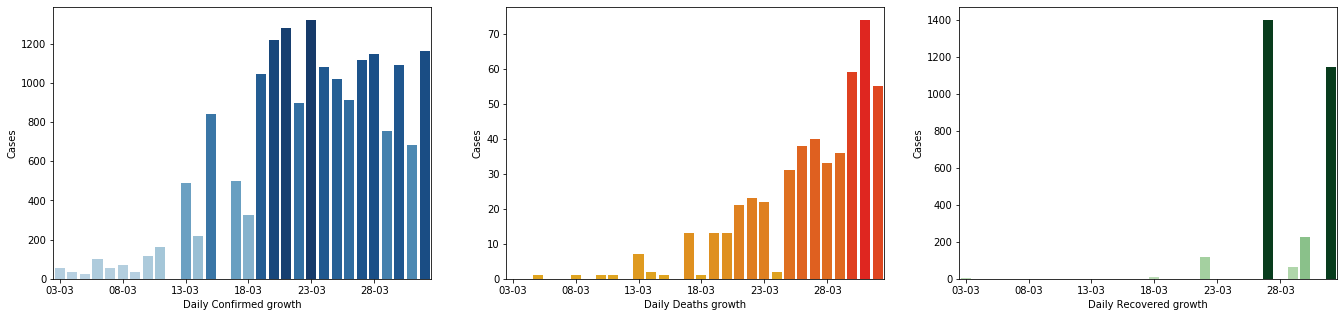

10 . Turkey
Confirmed: 15679 
Active: 15069.0 
Recovered: 333.0 
Deaths: 277


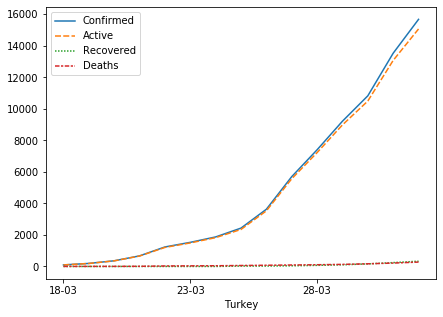


Daily growth for each types of cases



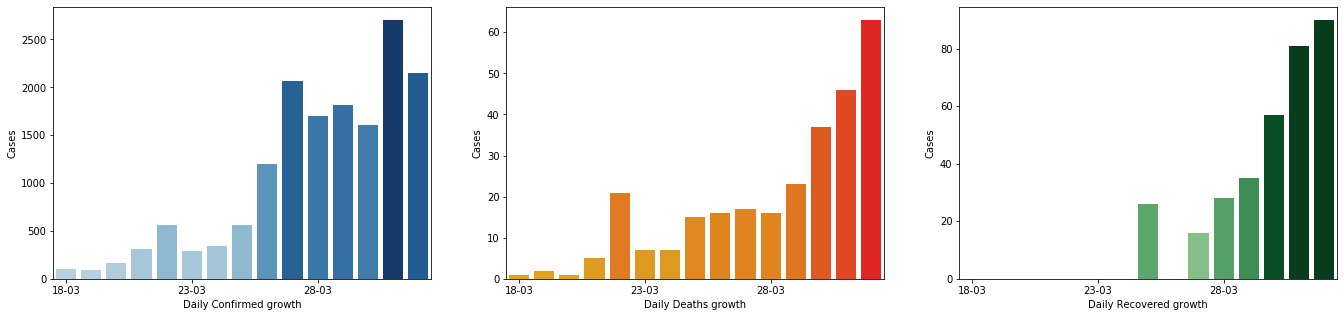

11 . Belgium
Confirmed: 13964 
Active: 11004.0 
Recovered: 2132.0 
Deaths: 828


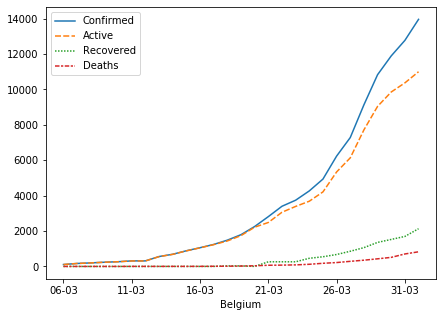


Daily growth for each types of cases



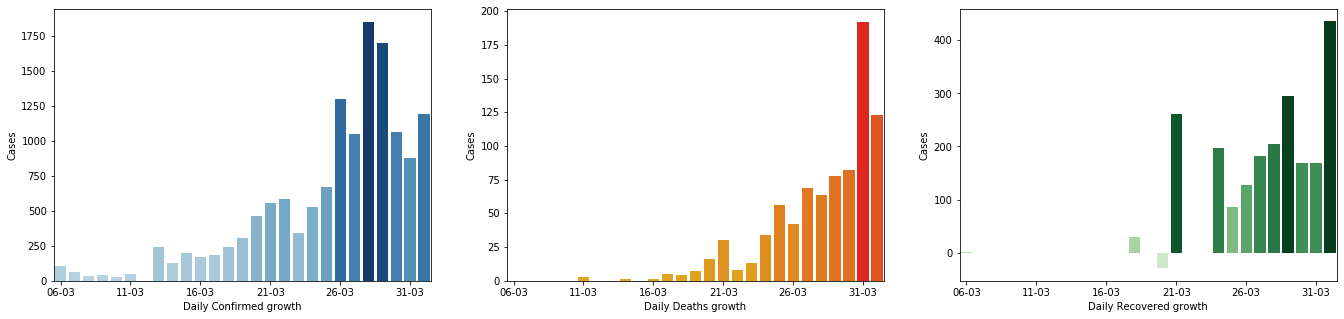

12 . Netherlands
Confirmed: 13696 
Active: 12261.0 
Recovered: 260.0 
Deaths: 1175


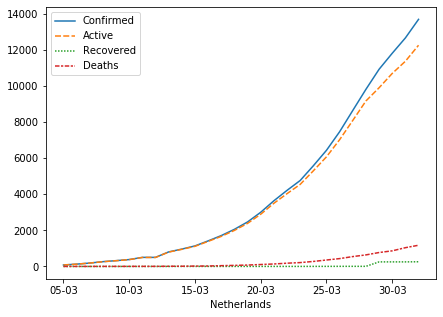


Daily growth for each types of cases



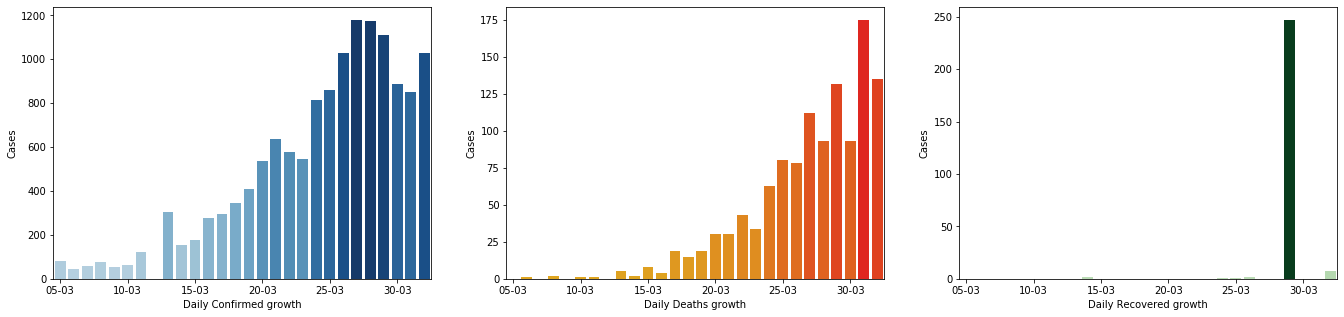

13 . Austria
Confirmed: 10711 
Active: 9129.0 
Recovered: 1436.0 
Deaths: 146


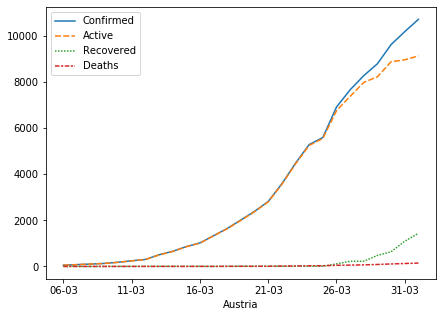


Daily growth for each types of cases



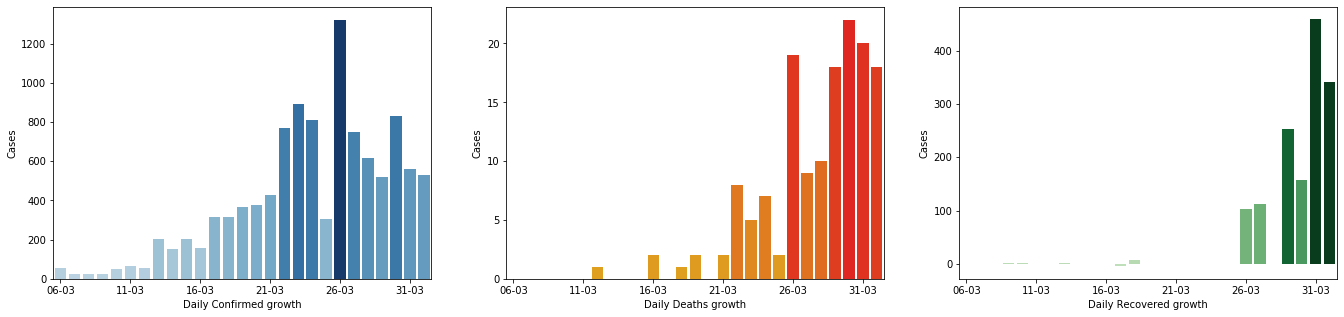

14 . Korea, South
Confirmed: 9887 
Active: 4155.0 
Recovered: 5567.0 
Deaths: 165


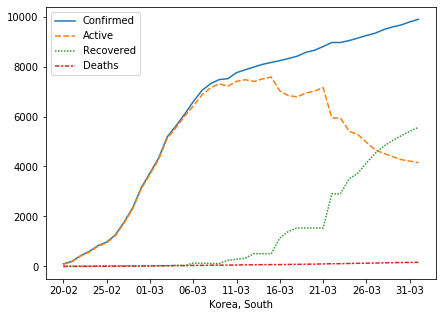


Daily growth for each types of cases



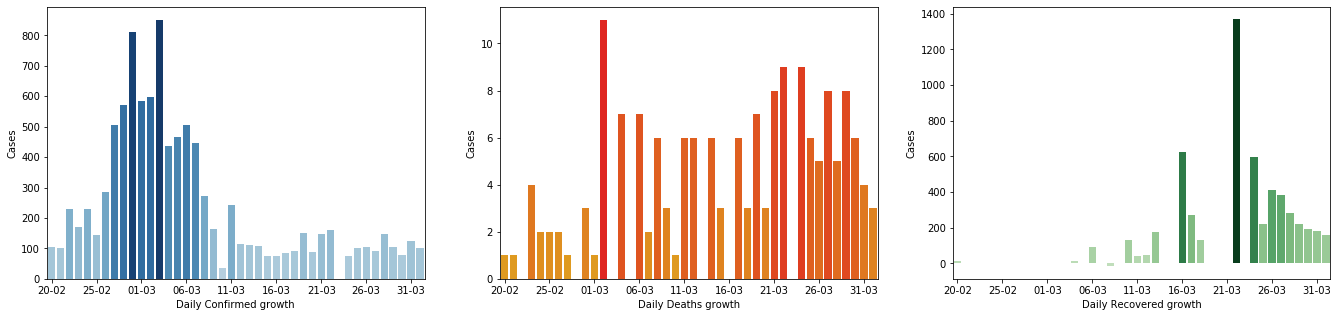

15 . Canada
Confirmed: 9560 
Active: 0.0 
Recovered: 0.0 
Deaths: 109


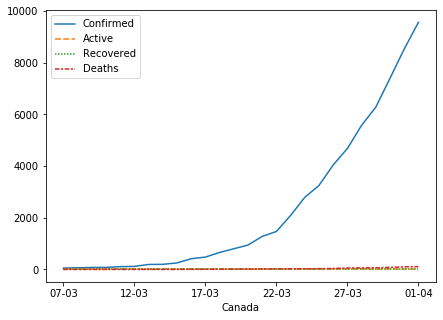


Daily growth for each types of cases



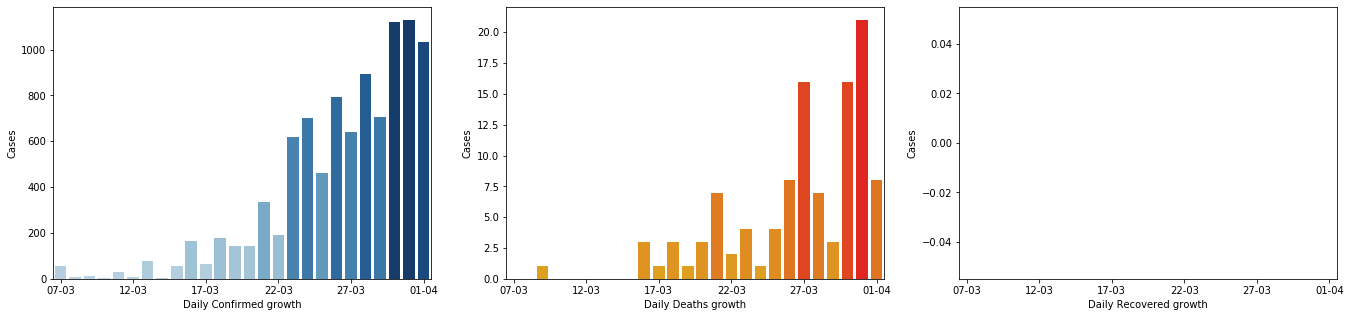

16 . Portugal
Confirmed: 8251 
Active: 8021.0 
Recovered: 43.0 
Deaths: 187


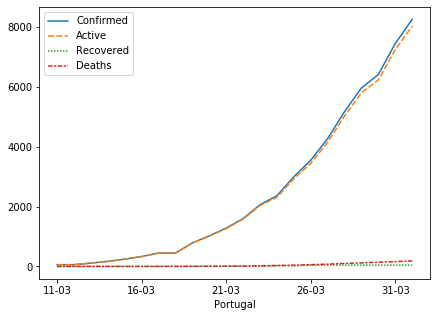


Daily growth for each types of cases



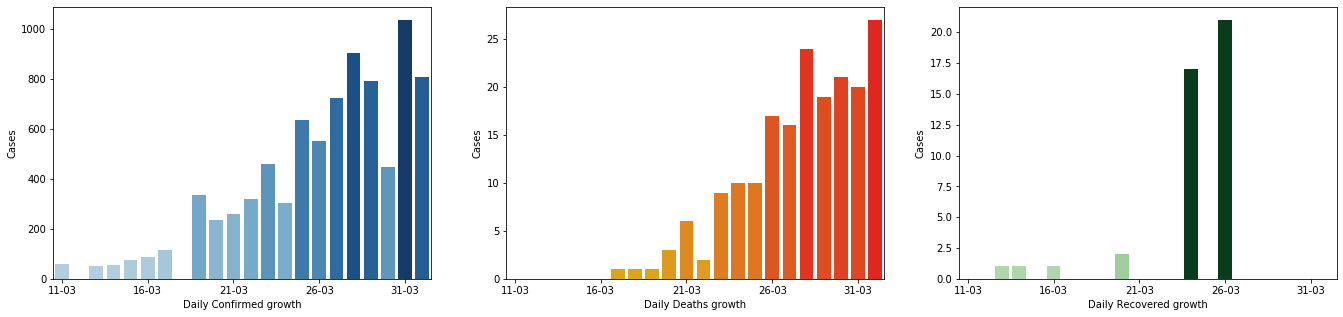

17 . Brazil
Confirmed: 6836 
Active: 6469.0 
Recovered: 127.0 
Deaths: 240


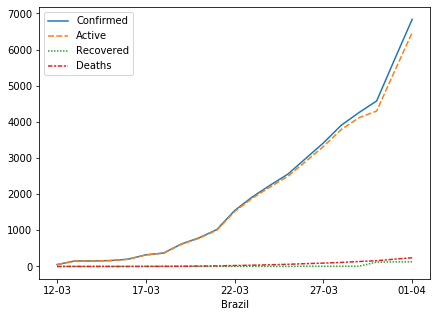


Daily growth for each types of cases



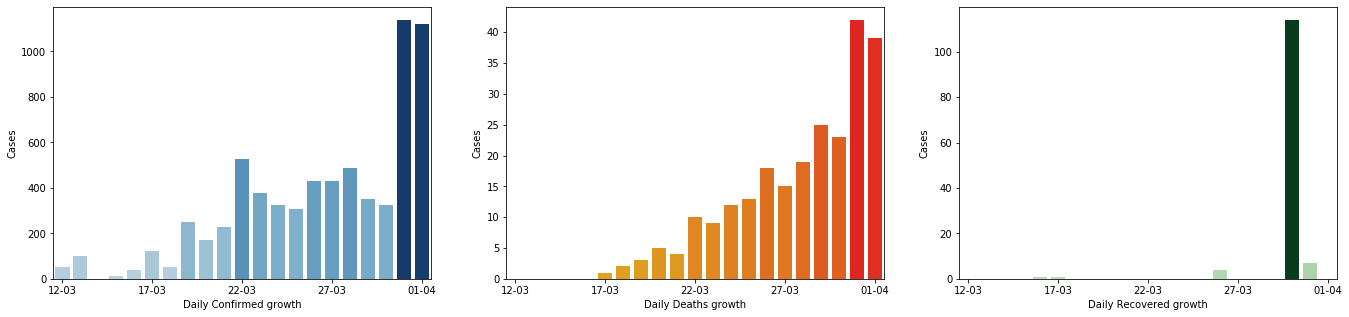

18 . Israel
Confirmed: 6092 
Active: 5825.0 
Recovered: 241.0 
Deaths: 26


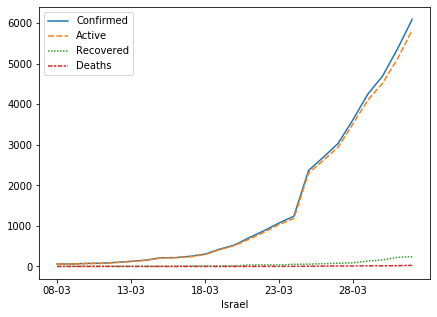


Daily growth for each types of cases



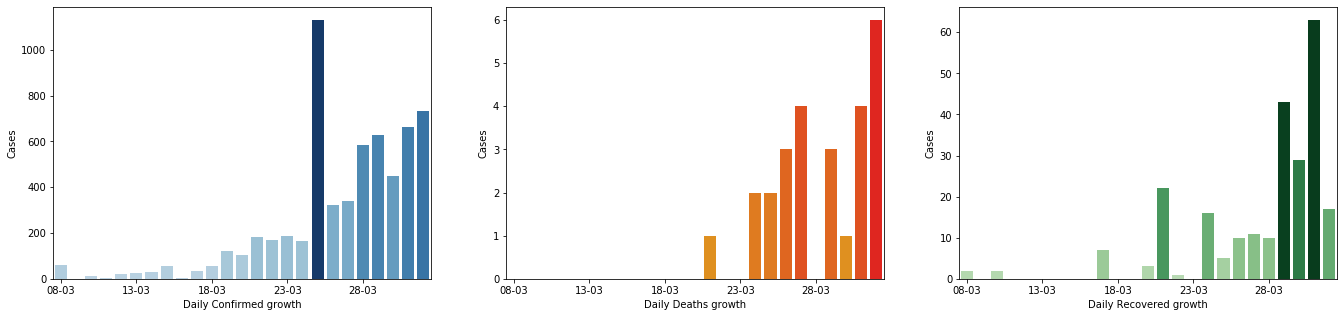

19 . Sweden
Confirmed: 4947 
Active: 4605.0 
Recovered: 103.0 
Deaths: 239


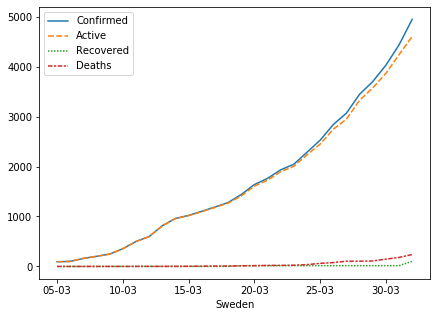


Daily growth for each types of cases



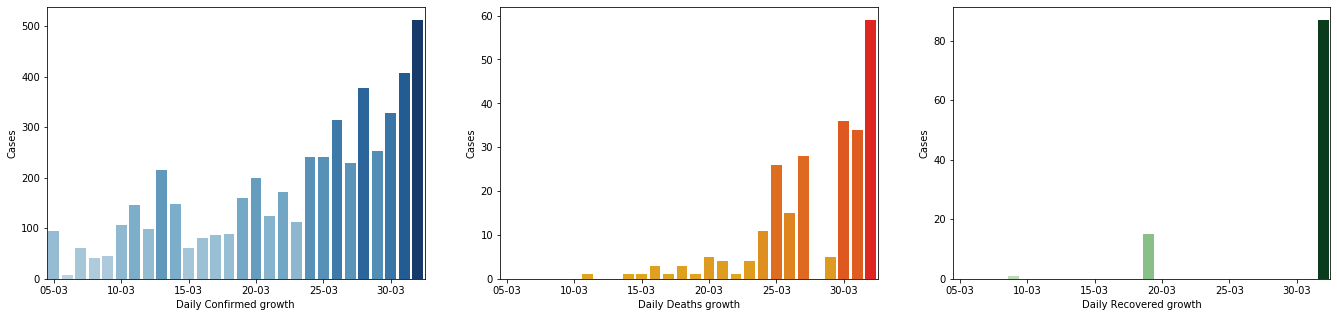

20 . Norway
Confirmed: 4863 
Active: 4806.0 
Recovered: 13.0 
Deaths: 44


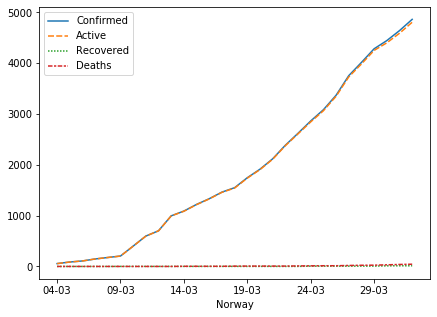


Daily growth for each types of cases



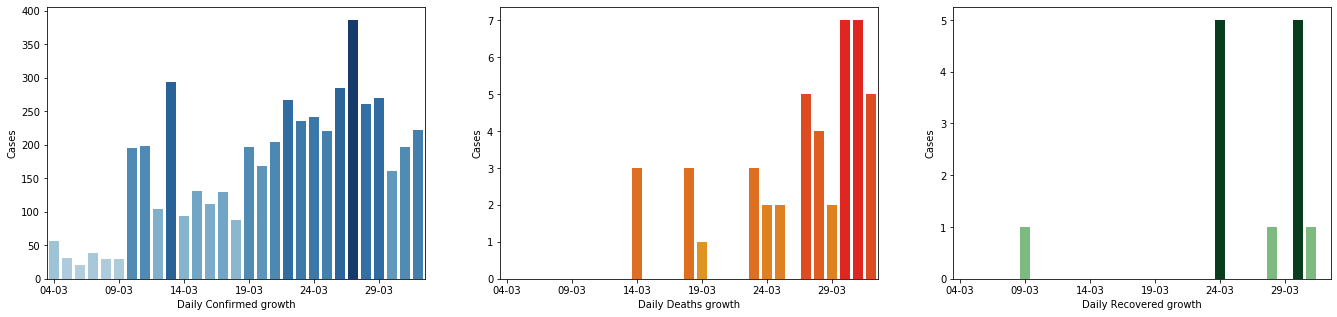

21 . Australia
Confirmed: 4862 
Active: 4420.0 
Recovered: 422.0 
Deaths: 20


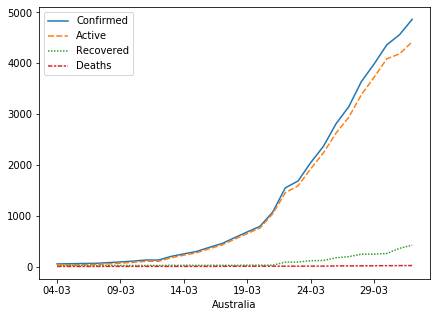


Daily growth for each types of cases



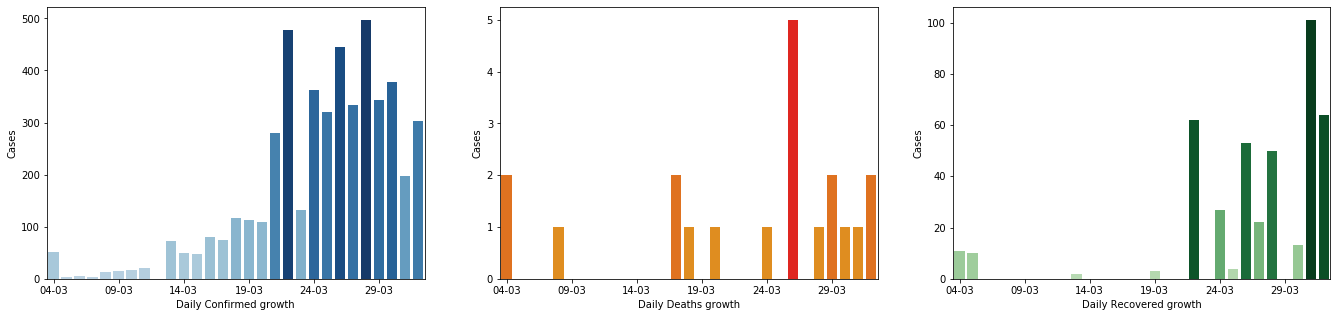

22 . Czechia
Confirmed: 3508 
Active: 3408.0 
Recovered: 61.0 
Deaths: 39


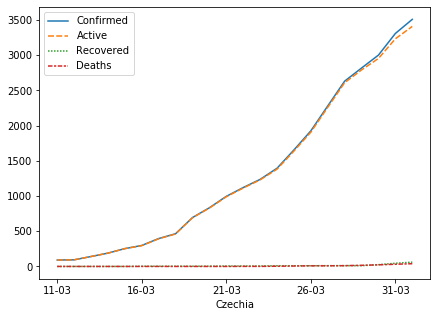


Daily growth for each types of cases



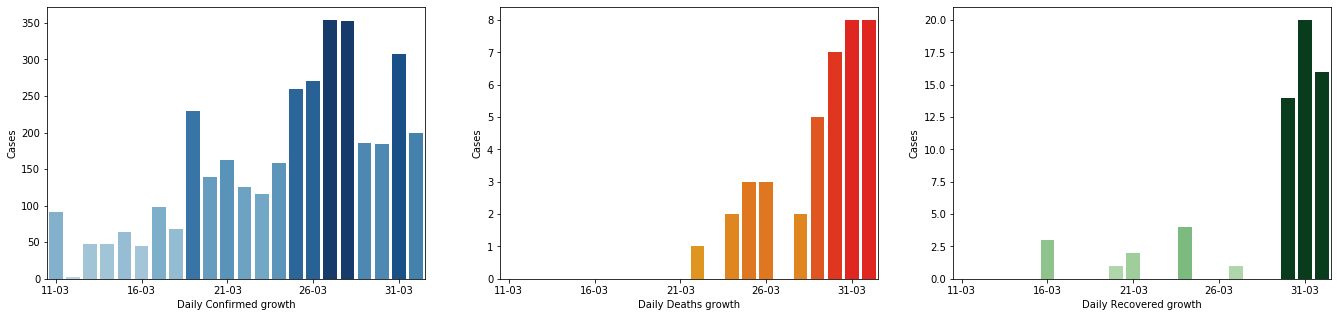

23 . Ireland
Confirmed: 3447 
Active: 3357.0 
Recovered: 5.0 
Deaths: 85


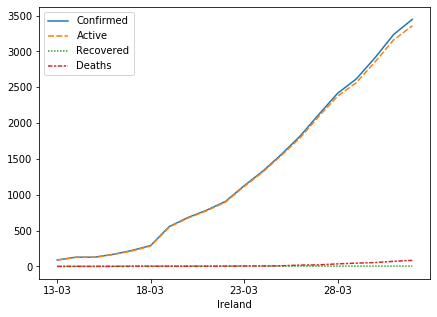


Daily growth for each types of cases



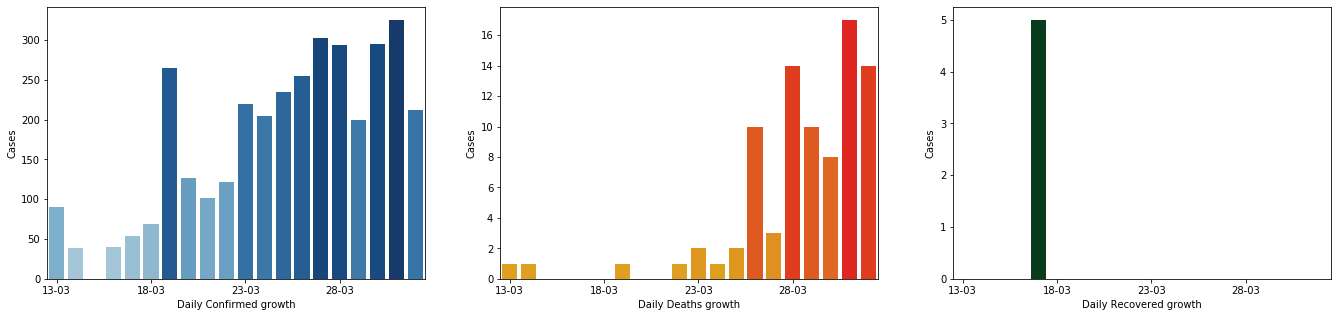

24 . Denmark
Confirmed: 3290 
Active: 2215.0 
Recovered: 971.0 
Deaths: 104


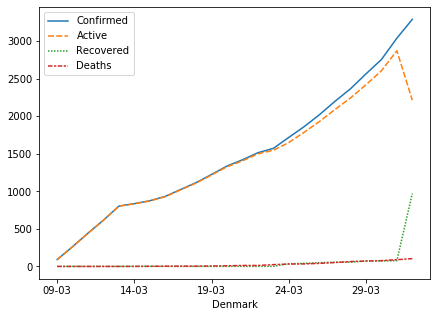


Daily growth for each types of cases



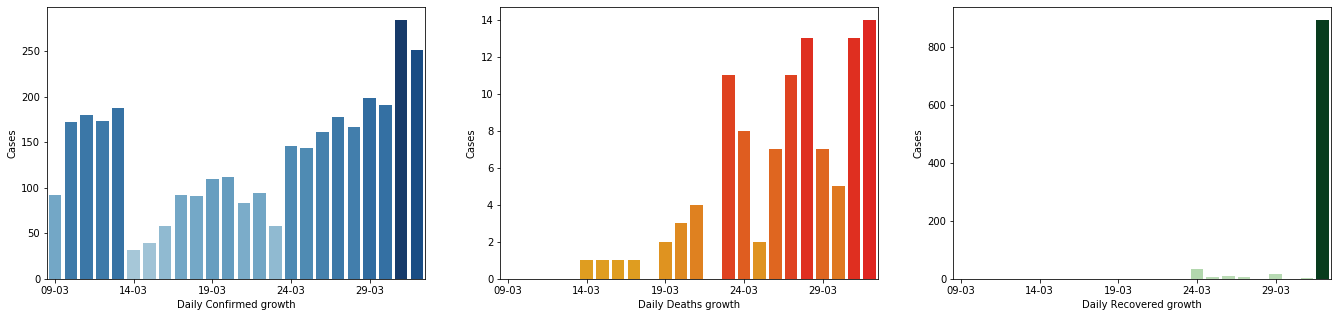

25 . Chile
Confirmed: 3031 
Active: 2781.0 
Recovered: 234.0 
Deaths: 16


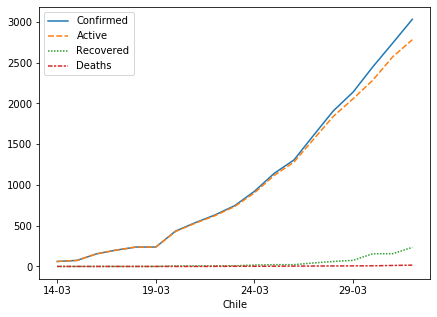


Daily growth for each types of cases



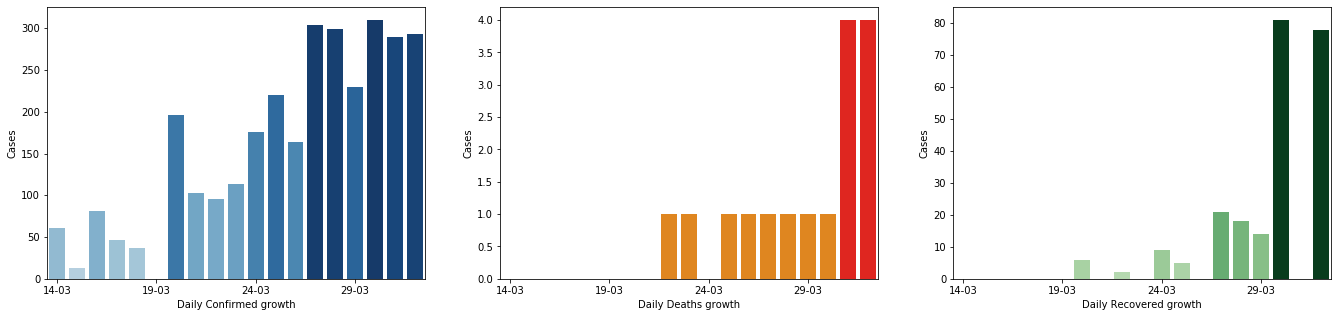

26 . Malaysia
Confirmed: 2908 
Active: 2218.0 
Recovered: 645.0 
Deaths: 45


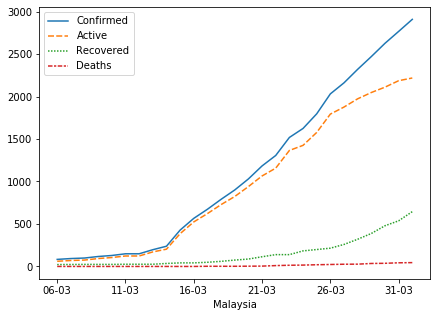


Daily growth for each types of cases



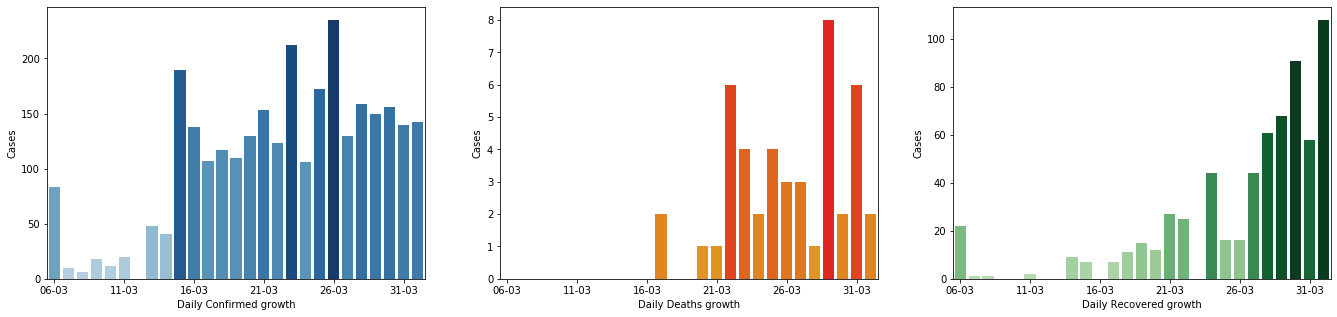

27 . Russia
Confirmed: 2777 
Active: 2563.0 
Recovered: 190.0 
Deaths: 24


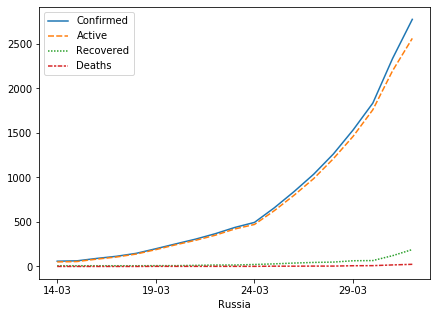


Daily growth for each types of cases



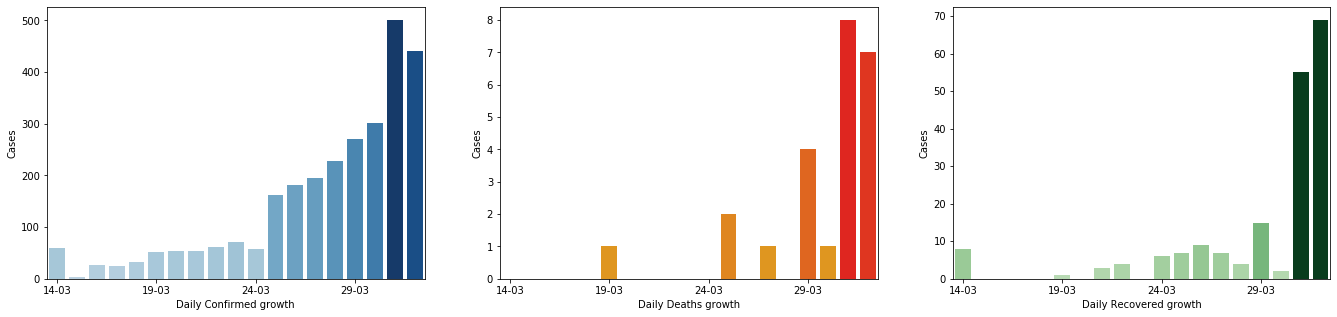

28 . Ecuador
Confirmed: 2748 
Active: 2597.0 
Recovered: 58.0 
Deaths: 93


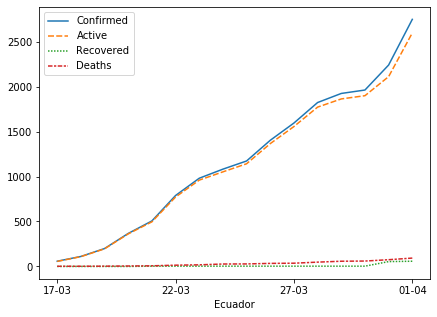


Daily growth for each types of cases



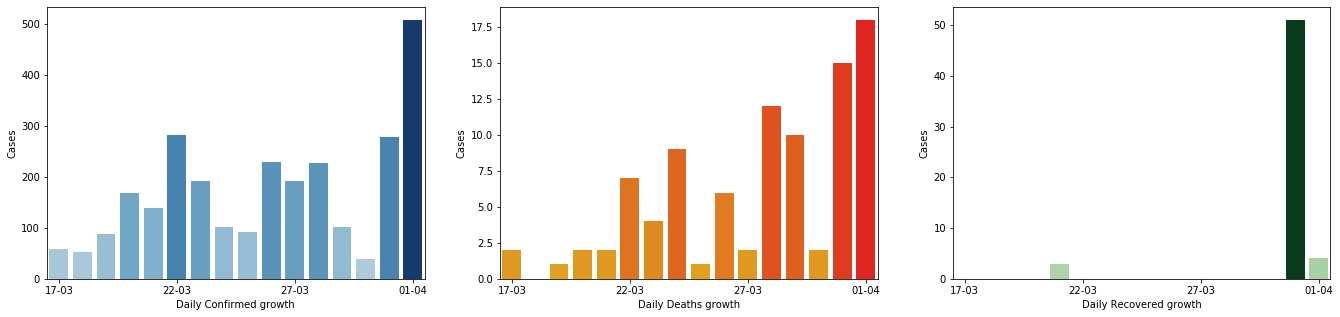

29 . Poland
Confirmed: 2554 
Active: 2464.0 
Recovered: 47.0 
Deaths: 43


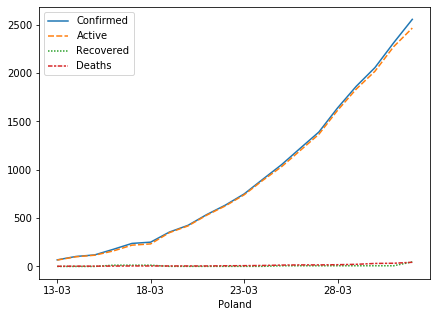


Daily growth for each types of cases



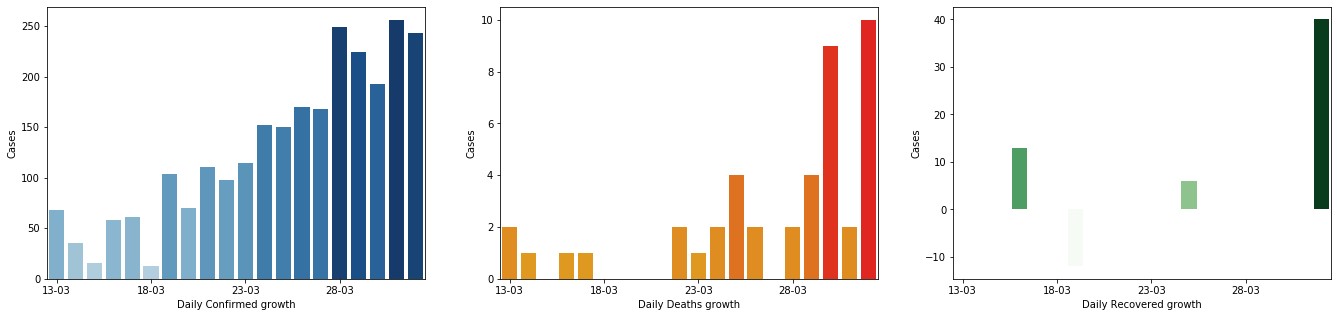

30 . Romania
Confirmed: 2460 
Active: 2116.0 
Recovered: 252.0 
Deaths: 92


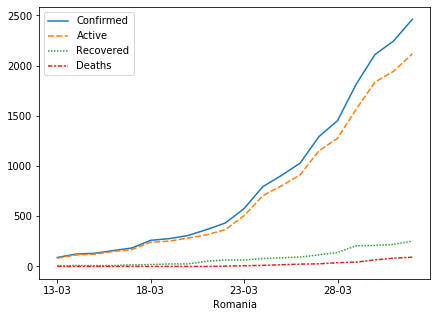


Daily growth for each types of cases



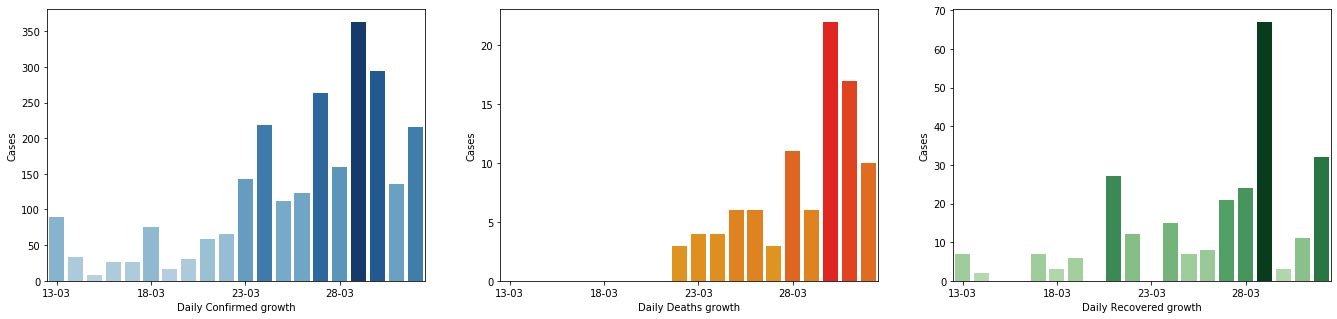

31 . Luxembourg
Confirmed: 2319 
Active: 2210.0 
Recovered: 80.0 
Deaths: 29


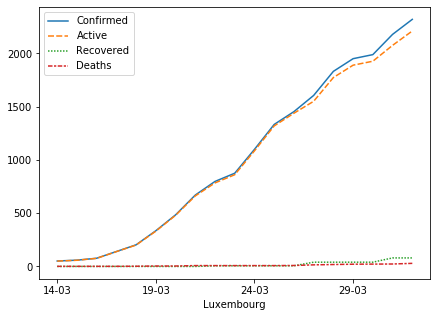


Daily growth for each types of cases



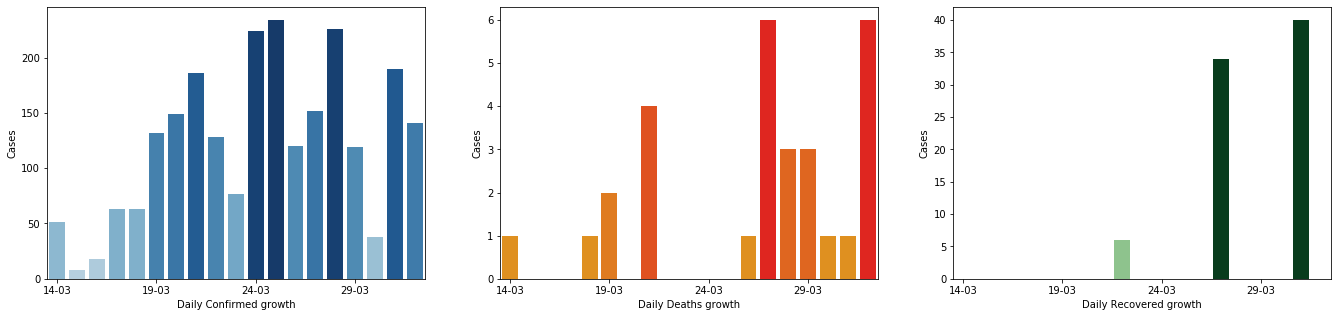

32 . Philippines
Confirmed: 2311 
Active: 2165.0 
Recovered: 50.0 
Deaths: 96


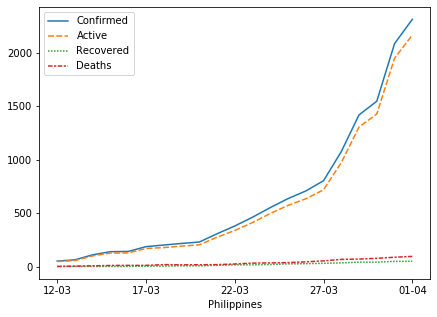


Daily growth for each types of cases



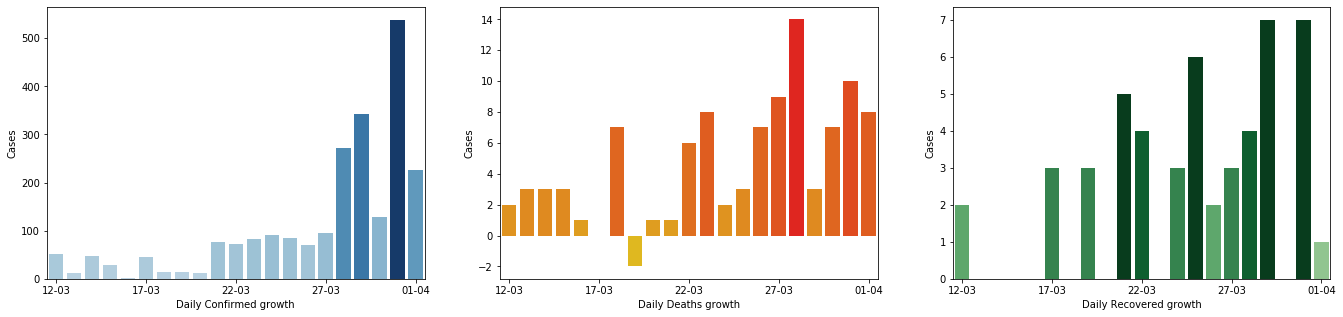

33 . Japan
Confirmed: 2178 
Active: 1649.0 
Recovered: 472.0 
Deaths: 57


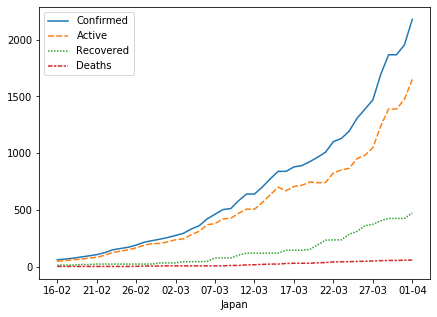


Daily growth for each types of cases



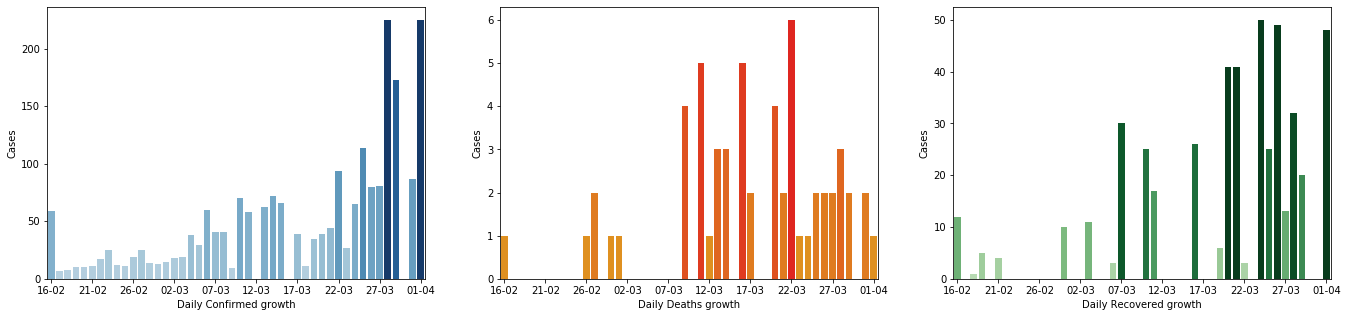

34 . Pakistan
Confirmed: 2118 
Active: 1997.0 
Recovered: 94.0 
Deaths: 27


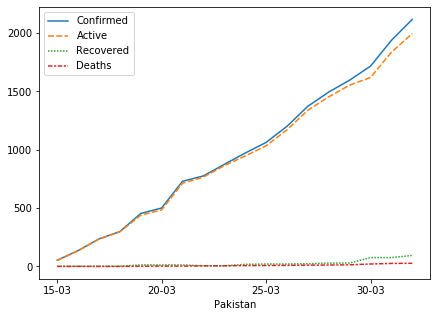


Daily growth for each types of cases



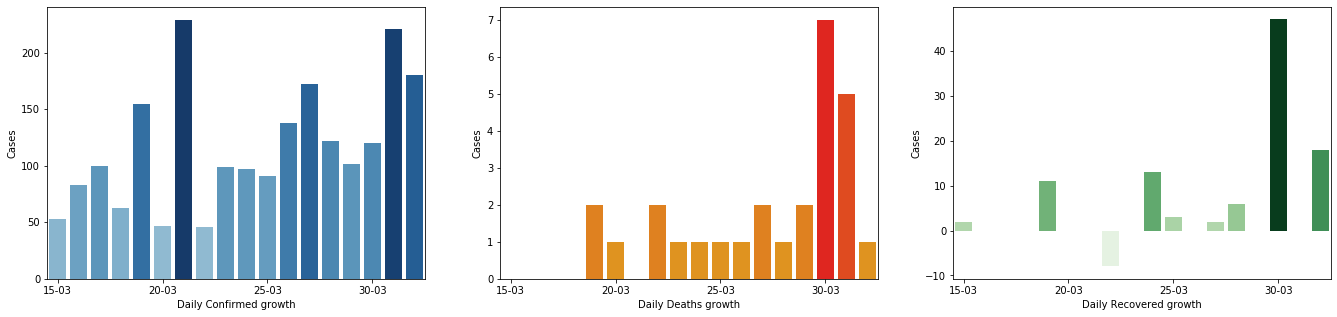

35 . India
Confirmed: 1998 
Active: 1792.0 
Recovered: 148.0 
Deaths: 58


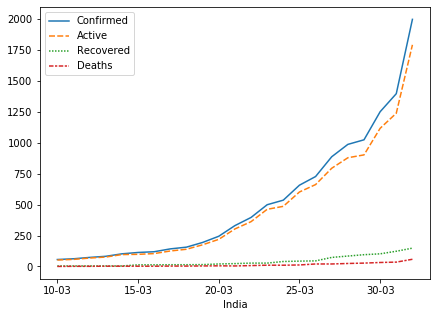


Daily growth for each types of cases



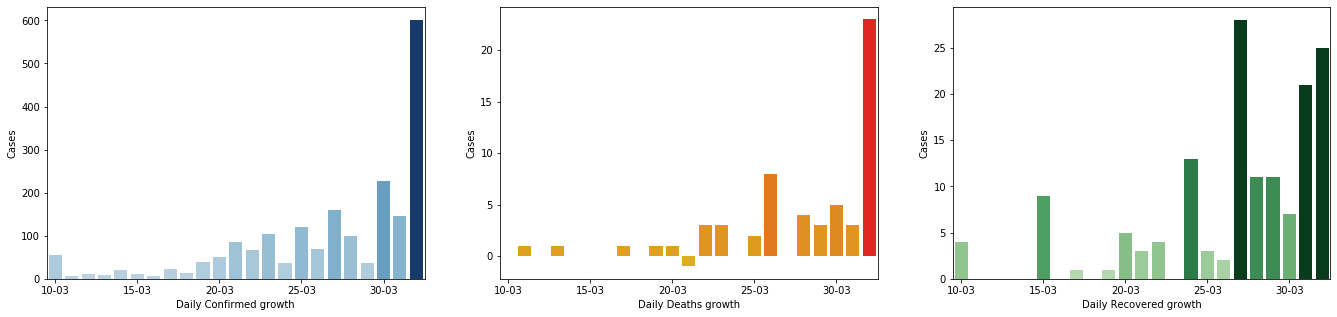

36 . Thailand
Confirmed: 1771 
Active: 1254.0 
Recovered: 505.0 
Deaths: 12


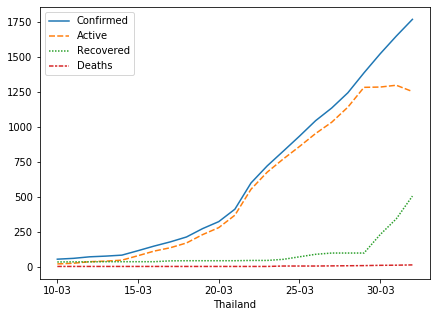


Daily growth for each types of cases



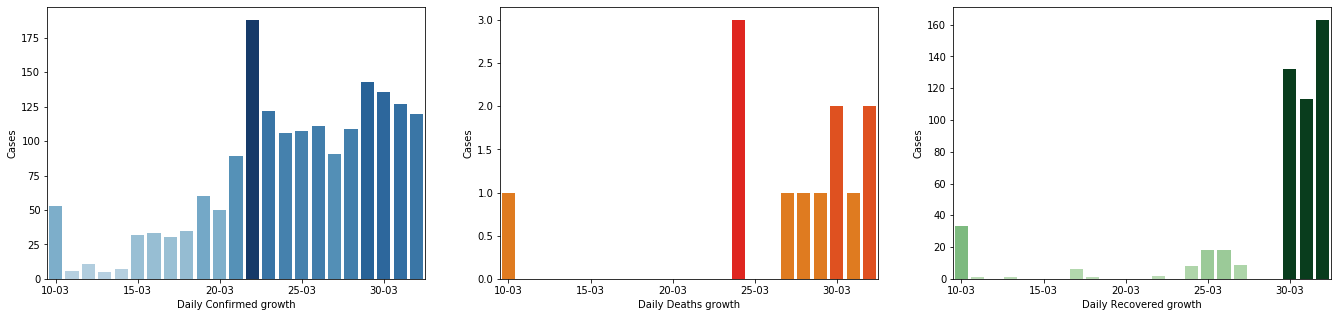

37 . Saudi Arabia
Confirmed: 1720 
Active: 1440.0 
Recovered: 264.0 
Deaths: 16


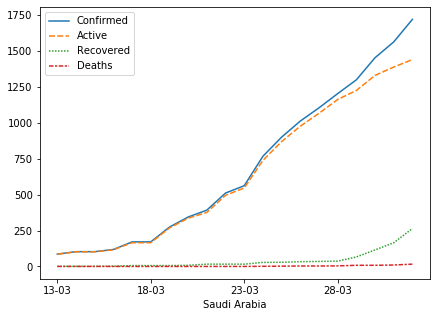


Daily growth for each types of cases



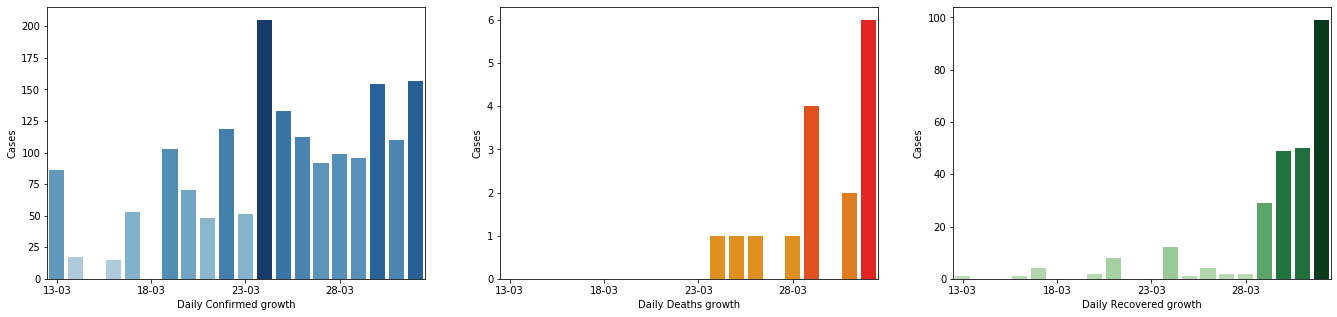

38 . Indonesia
Confirmed: 1677 
Active: 1417.0 
Recovered: 103.0 
Deaths: 157


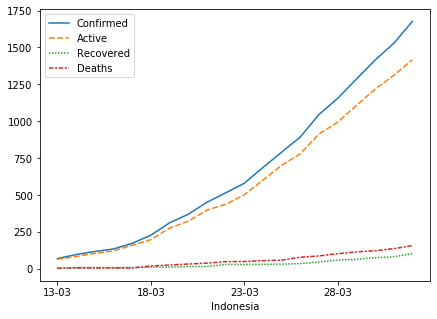


Daily growth for each types of cases



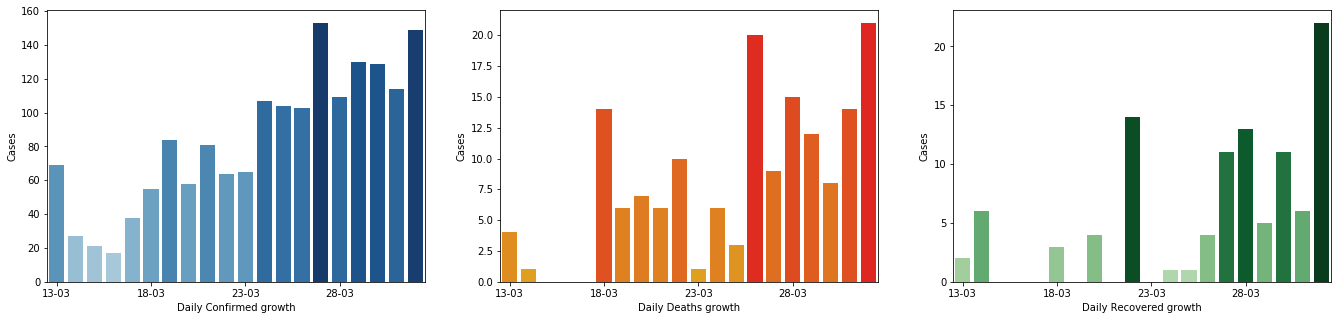

39 . Finland
Confirmed: 1446 
Active: 1419.0 
Recovered: 10.0 
Deaths: 17


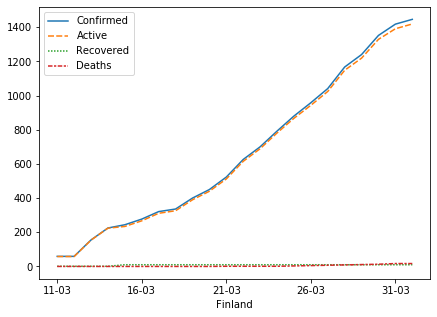


Daily growth for each types of cases



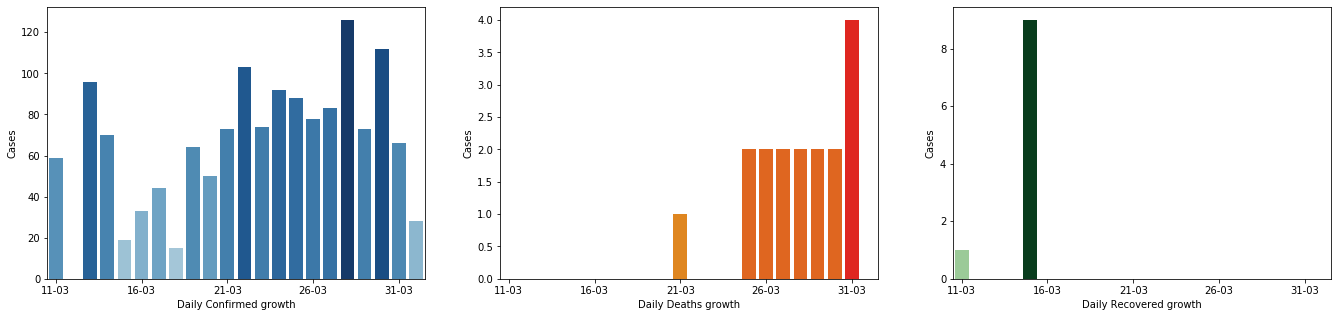

40 . Greece
Confirmed: 1415 
Active: 1313.0 
Recovered: 52.0 
Deaths: 50


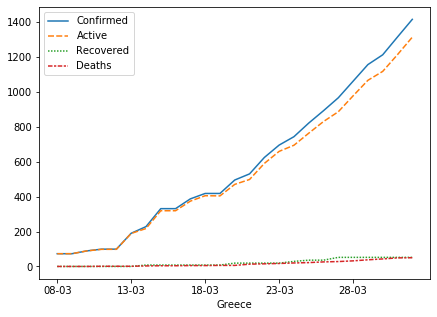


Daily growth for each types of cases



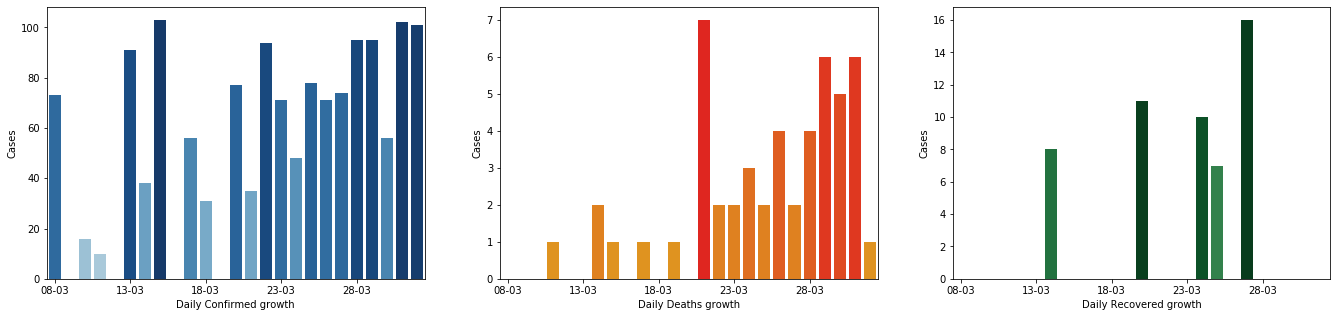

41 . South Africa
Confirmed: 1380 
Active: 1325.0 
Recovered: 50.0 
Deaths: 5


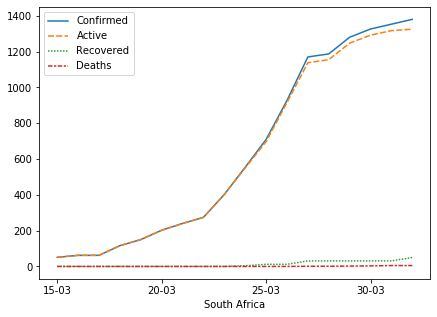


Daily growth for each types of cases



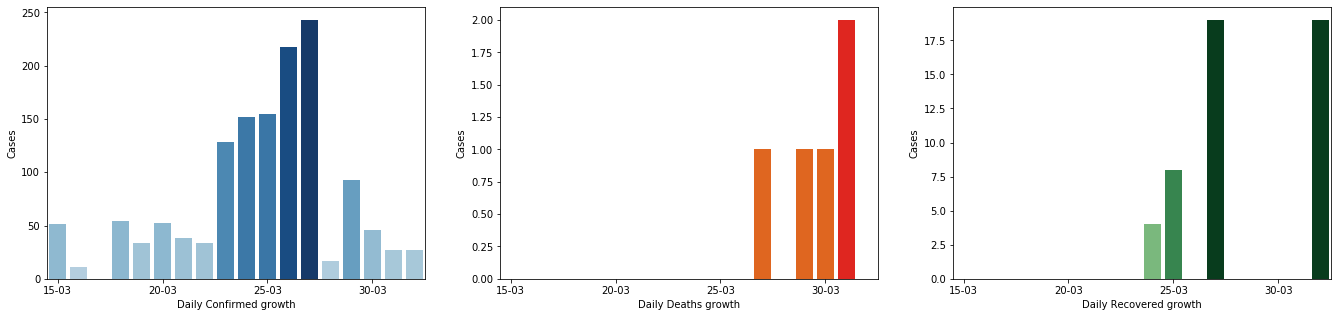

42 . Peru
Confirmed: 1323 
Active: 891.0 
Recovered: 394.0 
Deaths: 38


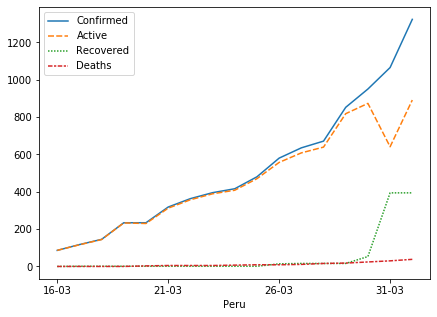


Daily growth for each types of cases



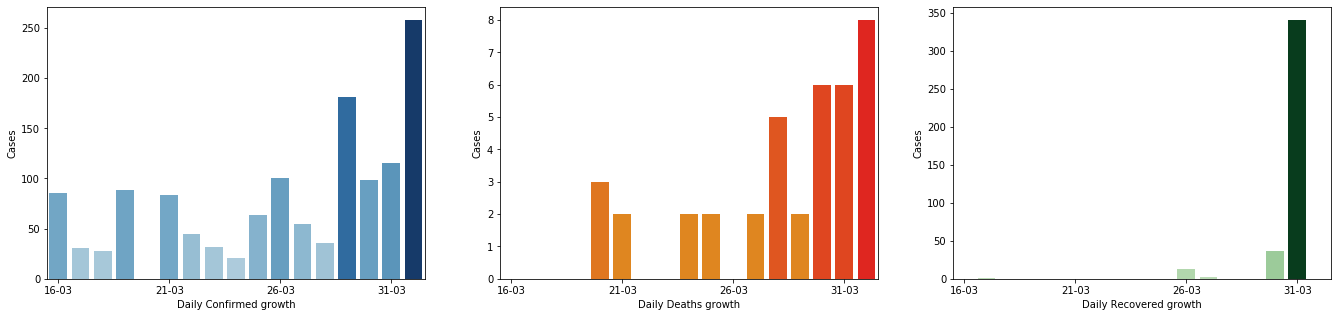

43 . Dominican Republic
Confirmed: 1284 
Active: 1218.0 
Recovered: 9.0 
Deaths: 57


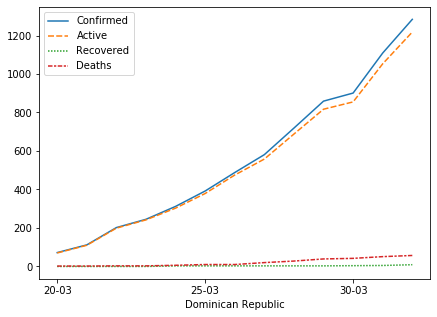


Daily growth for each types of cases



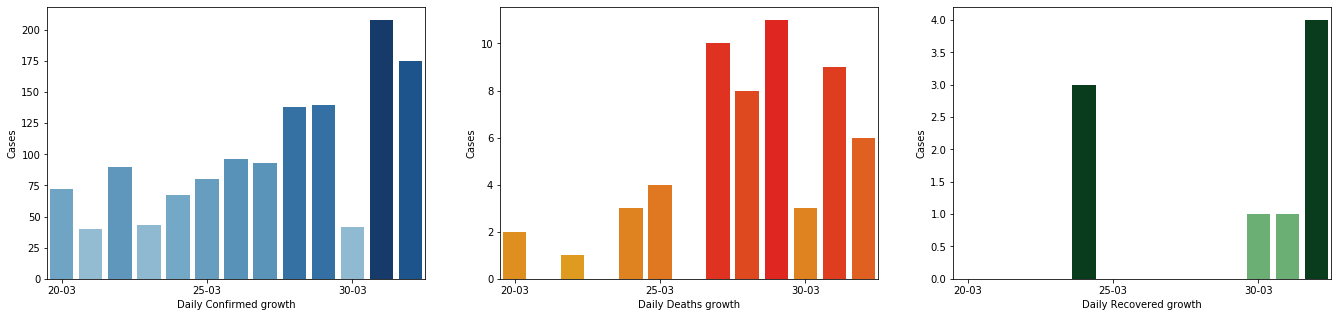

44 . Iceland
Confirmed: 1220 
Active: 993.0 
Recovered: 225.0 
Deaths: 2


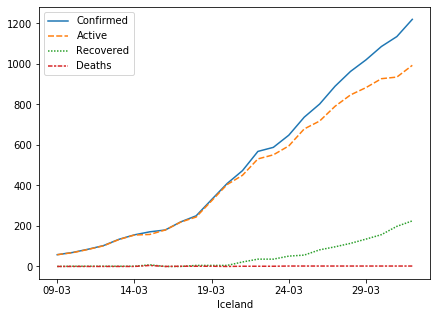


Daily growth for each types of cases



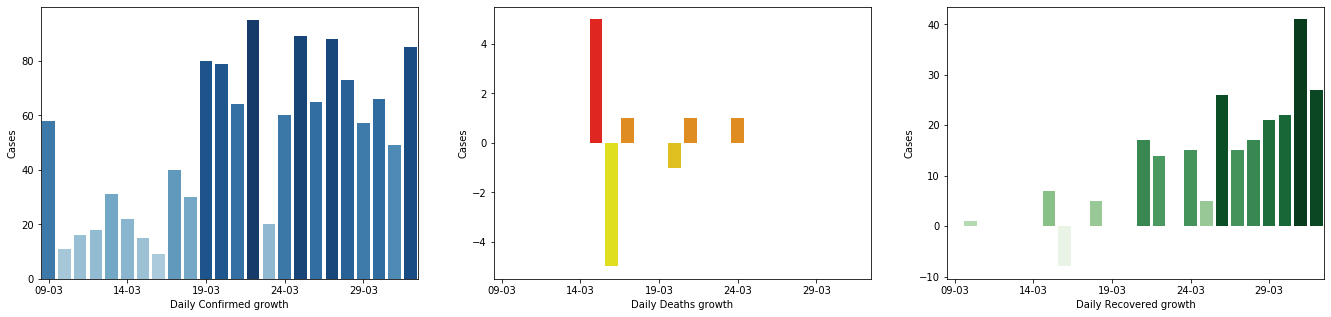

45 . Mexico
Confirmed: 1215 
Active: 1151.0 
Recovered: 35.0 
Deaths: 29


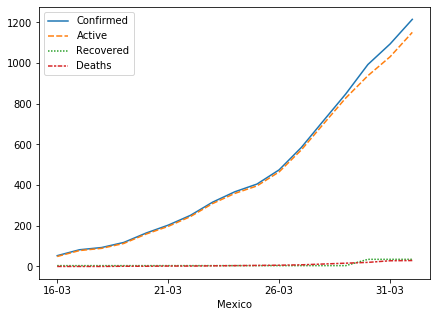


Daily growth for each types of cases



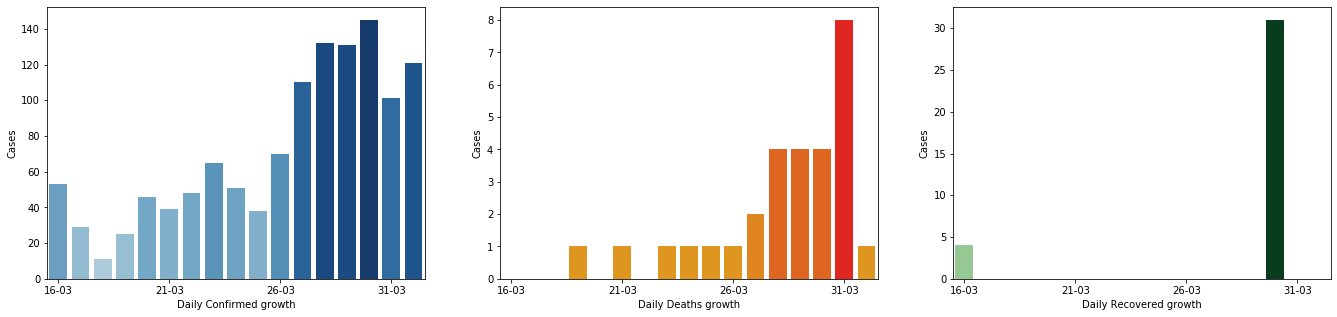

46 . Panama
Confirmed: 1181 
Active: 1142.0 
Recovered: 9.0 
Deaths: 30


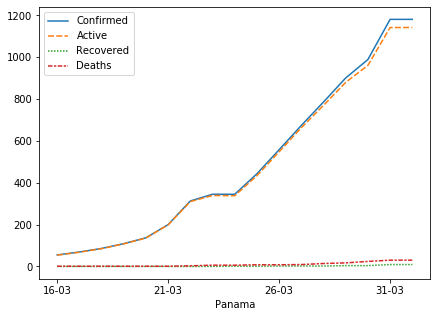


Daily growth for each types of cases



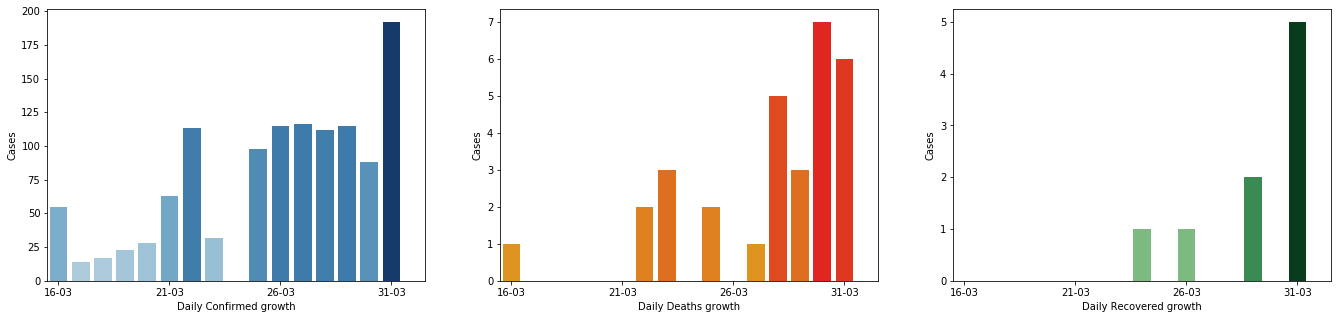

47 . Colombia
Confirmed: 1065 
Active: 1009.0 
Recovered: 39.0 
Deaths: 17


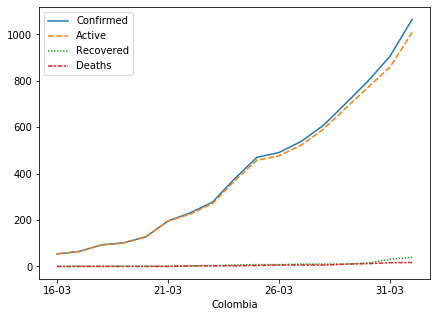


Daily growth for each types of cases



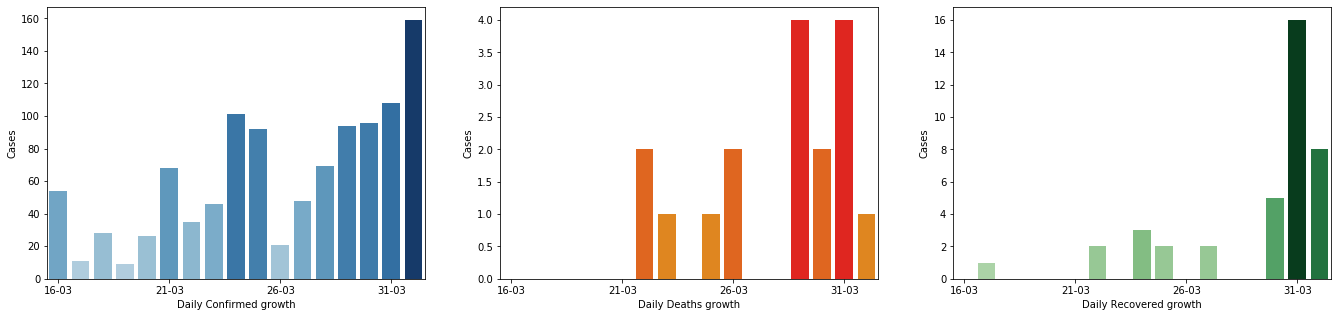

48 . Serbia
Confirmed: 1060 
Active: 1032.0 
Recovered: 0.0 
Deaths: 28


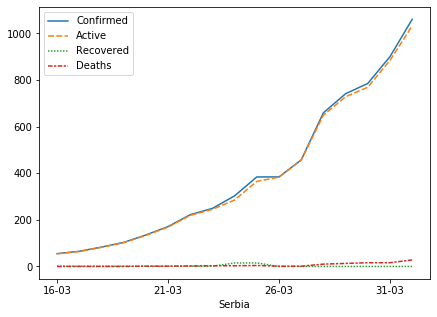


Daily growth for each types of cases



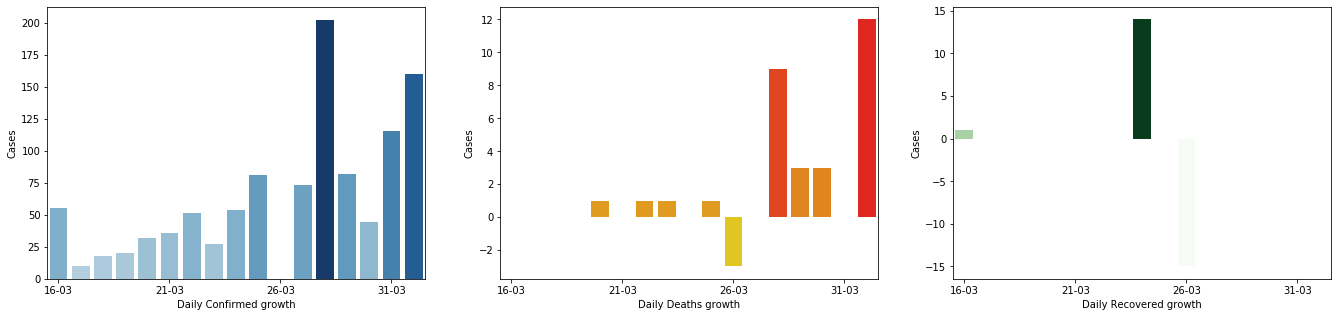

49 . Argentina
Confirmed: 1054 
Active: 778.0 
Recovered: 248.0 
Deaths: 28


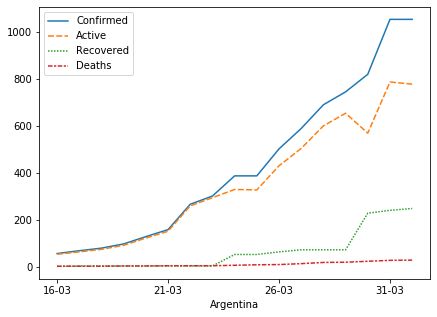


Daily growth for each types of cases



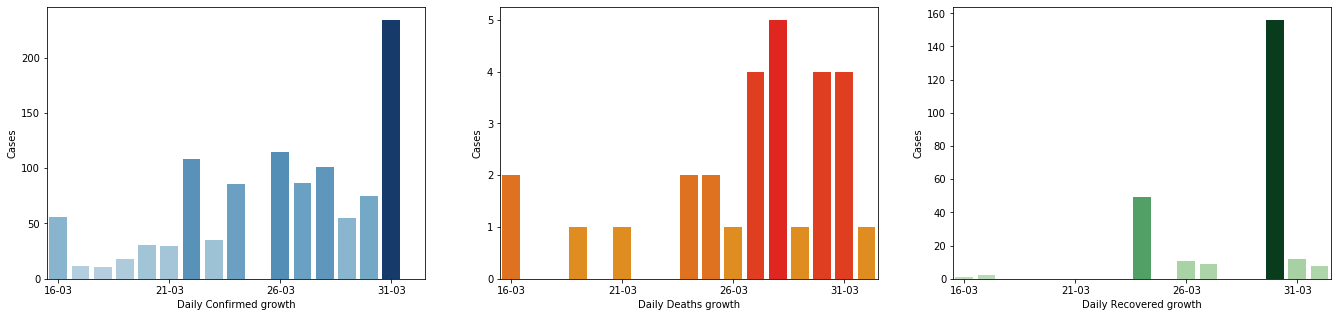

50 . Singapore
Confirmed: 1000 
Active: 752.0 
Recovered: 245.0 
Deaths: 3


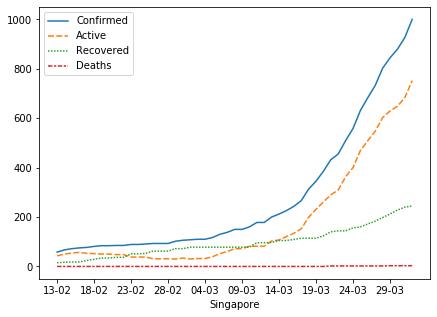


Daily growth for each types of cases



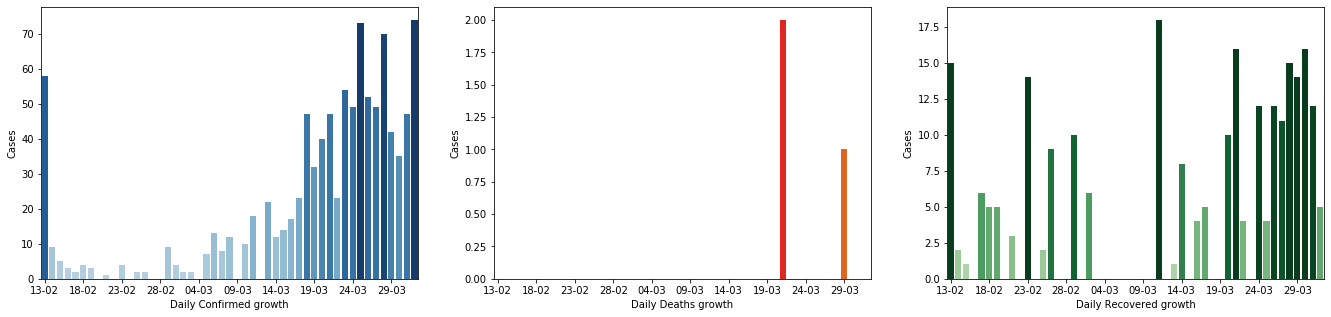

In [29]:
for index, country in enumerate(top_50.index):
    print(index+1,'.', country)
    print('Confirmed:', top_50.Confirmed[country],'\n'\
          'Active:', top_50.Active[country],'\n'\
          'Recovered:', top_50.Recovered[country],'\n'\
          'Deaths:', top_50.Deaths[country]
         )
    df, date_range = prepare_data(covid_19_df, country, 50)
    df = add_data(df)
    show_increment(df, country, date_range)